In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
shap.initjs()

c:\Users\ksomu-ctr\Documents\Practicum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Consolidation

In [3]:
tmdm_data = pd.read_csv("TMDM_Base.csv")
tmdm_data['TRANSIT_DATE'] = pd.to_datetime(tmdm_data['TRANSIT_DATE'])
tmdm_data['PROPERTY_TAG'] = tmdm_data['PROPERTY_TAG'].astype(int)
tmdm_data

,CALENDAR_ID,TRANSIT_DATE,TRIP_ID,TRIP_EDGE,PROPERTY_TAG,VEHICLE_ID,ADHERENCE,TIME_PERIOD,ROUTE_ABBR,ROUTE_DIRECTION_NAME,...,TIME_POINT_INTERVAL_ID,INTERVAL_DISTANCE,SCHEDULED_TRAVEL_TIME,ACTUAL_TRAVEL_TIME_WITH_DWELL,COMPLETE_TRIP,ARRIVAL_HOUR,ARRIVAL_TIME_ROUNDED,ARRIVAL_DATETIME_TRAFFIC,ROUTE_PATTERN,day_of_week
0,120240501,2024-05-01,9074015.0,0,1833,1894.0,-41.0,Before 6 AM,78,Westbound,...,27.0,5354.0,180.0,250.0,1.0,4,04:15:00,2024-05-01 04:15:00,78 Westbound IB,Wednesday
1,120240501,2024-05-01,9074015.0,0,1833,1894.0,-302.0,Before 6 AM,78,Westbound,...,350.0,9309.0,360.0,621.0,1.0,4,04:30:00,2024-05-01 04:30:00,78 Westbound IB,Wednesday
2,120240501,2024-05-01,9074015.0,2,1833,1894.0,-387.0,Before 6 AM,78,Westbound,...,906.0,10748.0,420.0,505.0,1.0,4,04:45:00,2024-05-01 04:45:00,78 Westbound IB,Wednesday
3,120240501,2024-05-01,9074017.0,0,1833,1894.0,51.0,Before 6 AM,78,Westbound,...,27.0,5354.0,180.0,162.0,1.0,4,05:00:00,2024-05-01 05:00:00,78 Westbound IB,Wednesday
4,120240501,2024-05-01,9074017.0,0,1833,1894.0,-103.0,Before 6 AM,78,Westbound,...,350.0,9309.0,360.0,514.0,1.0,5,05:15:00,2024-05-01 05:15:00,78 Westbound IB,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136109,120250430,2025-04-30,9548171.0,0,1959,2027.0,-243.0,Midday: 9 AM to 3 PM,197,Westbound,...,1118.0,28908.0,1080.0,1160.0,1.0,11,11:45:00,2025-04-30 11:45:00,197 Westbound WB,Wednesday
136110,120250430,2025-04-30,9548171.0,2,1959,2027.0,-16.0,Midday: 9 AM to 3 PM,197,Westbound,...,1698.0,19090.0,720.0,493.0,1.0,11,11:45:00,2025-04-30 11:45:00,197 Westbound WB,Wednesday
136111,120250430,2025-04-30,9548175.0,0,1959,2027.0,-22.0,Midday: 9 AM to 3 PM,197,Westbound,...,116.0,15943.0,540.0,520.0,1.0,14,14:15:00,2025-04-30 14:15:00,197 Westbound WB,Wednesday
136112,120250430,2025-04-30,9548175.0,0,1959,2027.0,-208.0,Midday: 9 AM to 3 PM,197,Westbound,...,1118.0,28908.0,1080.0,1266.0,1.0,14,14:45:00,2025-04-30 14:45:00,197 Westbound WB,Wednesday


In [4]:
weather_data = pd.read_csv("Weather_Combined.csv")
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data

,Date,Hour,Temperature (F),Precipitation (in)
0,2025-04-30,20,76.3,0.0
1,2025-04-30,5,63.3,0.0
2,2025-04-30,4,63.7,0.0
3,2025-04-30,3,65.3,0.0
4,2025-04-30,2,64.8,0.0
...,...,...,...,...
8755,2024-05-01,7,64.4,0.0
8756,2024-05-01,6,58.5,0.0
8757,2024-05-01,5,56.8,0.0
8758,2024-05-01,4,56.8,0.0


In [5]:
operator_data = pd.read_csv("Dynamic_Operator_Data.csv")
operator_data['ACTIVATION_DATE'] = pd.to_datetime(operator_data['ACTIVATION_DATE'])
operator_data['DEACTIVATION_DATE'] = pd.to_datetime(operator_data['DEACTIVATION_DATE'])
operator_data['CALENDAR_DATE'] = pd.to_datetime(operator_data['CALENDAR_DATE'])

operator_data

,Operator2,Coaching_SessionQuantity,Coaching_DateLastSession,ONBOARD_LOGON_ID,ACTIVATION_DATE,DEACTIVATION_DATE,CALENDAR_DATE,Proportion_Early,Proportion_Late,Proportion_On_Time,Work_Experience,Days_Since_Last_Coaching,Days_Since_Last_Coaching_Cat
0,"Abdul-Mughnee,Ghayth-43206",NaN,NaN,43206,2019-06-24,NaT,2024-05-01,0.004803,0.024736,0.970461,1773,NaN,NaN
1,"Abdul-Mughnee,Ghayth-43206",NaN,NaN,43206,2019-06-24,NaT,2024-05-02,0.004773,0.024582,0.970644,1774,NaN,NaN
2,"Abdul-Mughnee,Ghayth-43206",NaN,NaN,43206,2019-06-24,NaT,2024-05-03,0.004720,0.024310,0.970970,1775,NaN,NaN
3,"Abdul-Mughnee,Ghayth-43206",NaN,NaN,43206,2019-06-24,NaT,2024-05-04,0.004669,0.024977,0.970355,1776,NaN,NaN
4,"Abdul-Mughnee,Ghayth-43206",NaN,NaN,43206,2019-06-24,NaT,2024-05-07,0.004708,0.024953,0.970339,1779,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135060,"Zuniga,Josue-44661",NaN,NaN,44661,2020-02-03,NaT,2025-04-24,0.015416,0.091470,0.893114,1907,NaN,NaN
135061,"Zuniga,Josue-44661",NaN,NaN,44661,2020-02-03,NaT,2025-04-27,0.015416,0.091470,0.893114,1910,NaN,NaN
135062,"Zuniga,Josue-44661",NaN,NaN,44661,2020-02-03,NaT,2025-04-28,0.015416,0.091470,0.893114,1911,NaN,NaN
135063,"Zuniga,Josue-44661",NaN,NaN,44661,2020-02-03,NaT,2025-04-29,0.015000,0.090000,0.895000,1912,NaN,NaN


In [7]:
maintenance_data=pd.read_csv("Bus_Maintenance.csv")
maintenance_data['Date'] = pd.to_datetime(maintenance_data['Date'])
maintenance_data

#Confirm if Equip. No. is Property Tag
#Afterwards calculate the length of service from In Service to the Transit Date

,Equip. No.,Date,Total_Symptoms,High_Severity_Symptoms,Length_of_Service
0,1401,2024-05-01,5,1,3865
1,1401,2024-05-02,5,1,3866
2,1401,2024-05-03,5,1,3867
3,1401,2024-05-04,5,1,3868
4,1401,2024-05-05,5,1,3869
...,...,...,...,...,...
199164,8006,2025-04-26,0,0,1091
199165,8006,2025-04-27,0,0,1092
199166,8006,2025-04-28,0,0,1093
199167,8006,2025-04-29,0,0,1094


In [8]:
passenger_flow=pd.read_csv("passenger_flow_export.csv")
passenger_flow

,TIME_POINT_INTERVAL_ID,TRIP_ID,CALENDAR_ID,Made_Stop_Ratio,BOARD,ALIGHT,Passenger_Activity
0,27,9074015,120240501,0.400000,3.0,0.0,3.0
1,350,9074015,120240501,0.600000,9.0,0.0,9.0
2,906,9074015,120240501,0.300000,2.0,16.0,18.0
3,27,9074017,120240501,0.400000,2.0,1.0,3.0
4,350,9074017,120240501,0.400000,6.0,1.0,7.0
...,...,...,...,...,...,...,...
246695,1118,9548171,120250430,0.250000,1.0,5.0,6.0
246696,1698,9548171,120250430,0.142857,1.0,1.0,2.0
246697,116,9548175,120250430,0.222222,3.0,1.0,4.0
246698,1118,9548175,120250430,0.300000,8.0,8.0,16.0


In [9]:
ritis_traffic  = pd.read_csv("RITIS_Traffic.csv")

ritis_traffic = ritis_traffic.rename(columns={
    'Timepoint Segment Id': 'TIME_POINT_INTERVAL_ID',
    'measurement_tstamp': 'ARRIVAL_DATETIME_TRAFFIC'
})


ritis_traffic

,ROUTE_PATTERN,TIME_POINT_INTERVAL_ID,ARRIVAL_DATETIME_TRAFFIC,traffic_travel_time
0,140 Southbound SB,1048,2024-05-01 00:00:00,417.338085
1,140 Southbound SB,1048,2024-05-01 00:15:00,409.568561
2,140 Southbound SB,1048,2024-05-01 00:30:00,418.129275
3,140 Southbound SB,1048,2024-05-01 00:45:00,418.491894
4,140 Southbound SB,1048,2024-05-01 01:00:00,424.170602
...,...,...,...,...
1051075,832 Westbound WB,1667,2025-04-30 22:45:00,382.324443
1051076,832 Westbound WB,1667,2025-04-30 23:00:00,375.389465
1051077,832 Westbound WB,1667,2025-04-30 23:15:00,382.563826
1051078,832 Westbound WB,1667,2025-04-30 23:30:00,371.595694


In [10]:
merge1 = pd.merge(
    tmdm_data,
    operator_data,
    left_on=['ONBOARD_LOGON_ID', 'TRANSIT_DATE'],
    right_on=['ONBOARD_LOGON_ID', 'CALENDAR_DATE'],
    how='inner'
)

merge1['TIME_POINT_INTERVAL_ID'] = merge1['TIME_POINT_INTERVAL_ID'].astype(int)
merge1['TRIP_ID'] = merge1['TRIP_ID'].astype(int)


#merge1.to_csv('merge1_validation.csv')
merge1


,CALENDAR_ID,TRANSIT_DATE,TRIP_ID,TRIP_EDGE,PROPERTY_TAG,VEHICLE_ID,ADHERENCE,TIME_PERIOD,ROUTE_ABBR,ROUTE_DIRECTION_NAME,...,Coaching_DateLastSession,ACTIVATION_DATE,DEACTIVATION_DATE,CALENDAR_DATE,Proportion_Early,Proportion_Late,Proportion_On_Time,Work_Experience,Days_Since_Last_Coaching,Days_Since_Last_Coaching_Cat
0,120240501,2024-05-01,9074015,0,1833,1894.0,-41.0,Before 6 AM,78,Westbound,...,NaN,2016-08-22,NaT,2024-05-01,0.009815,0.062548,0.927637,2809,NaN,NaN
1,120240501,2024-05-01,9074015,0,1833,1894.0,-302.0,Before 6 AM,78,Westbound,...,NaN,2016-08-22,NaT,2024-05-01,0.009815,0.062548,0.927637,2809,NaN,NaN
2,120240501,2024-05-01,9074015,2,1833,1894.0,-387.0,Before 6 AM,78,Westbound,...,NaN,2016-08-22,NaT,2024-05-01,0.009815,0.062548,0.927637,2809,NaN,NaN
3,120240501,2024-05-01,9074017,0,1833,1894.0,51.0,Before 6 AM,78,Westbound,...,NaN,2016-08-22,NaT,2024-05-01,0.009815,0.062548,0.927637,2809,NaN,NaN
4,120240501,2024-05-01,9074017,0,1833,1894.0,-103.0,Before 6 AM,78,Westbound,...,NaN,2016-08-22,NaT,2024-05-01,0.009815,0.062548,0.927637,2809,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135987,120250430,2025-04-30,9548171,0,1959,2027.0,-243.0,Midday: 9 AM to 3 PM,197,Westbound,...,2024-08-16,2004-11-01,NaT,2025-04-30,0.000000,0.123060,0.876940,7485,257.0,4.0
135988,120250430,2025-04-30,9548171,2,1959,2027.0,-16.0,Midday: 9 AM to 3 PM,197,Westbound,...,2024-08-16,2004-11-01,NaT,2025-04-30,0.000000,0.123060,0.876940,7485,257.0,4.0
135989,120250430,2025-04-30,9548175,0,1959,2027.0,-22.0,Midday: 9 AM to 3 PM,197,Westbound,...,2024-08-16,2004-11-01,NaT,2025-04-30,0.000000,0.123060,0.876940,7485,257.0,4.0
135990,120250430,2025-04-30,9548175,0,1959,2027.0,-208.0,Midday: 9 AM to 3 PM,197,Westbound,...,2024-08-16,2004-11-01,NaT,2025-04-30,0.000000,0.123060,0.876940,7485,257.0,4.0


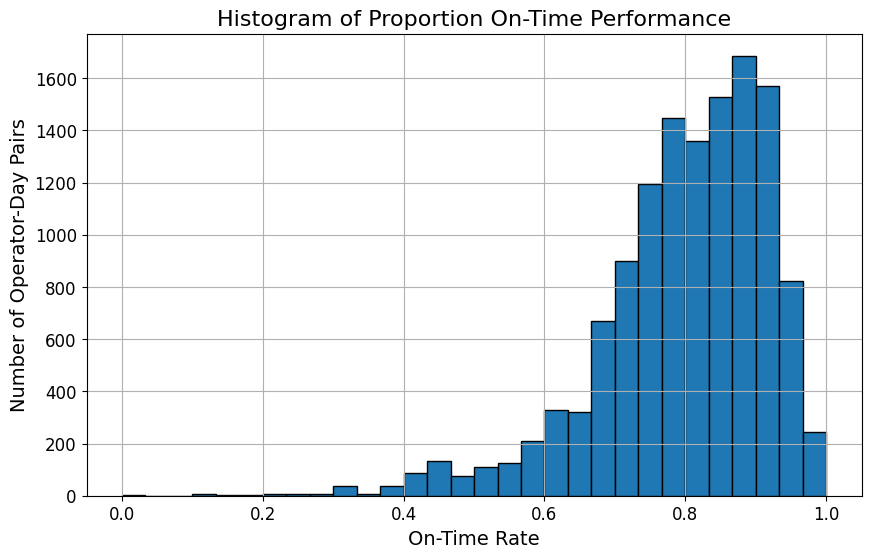

In [265]:
# Step 1: Group and collect Proportion_On_Time values
grouped_work_exp = (
    merge1
    .groupby(['Operator2', 'CALENDAR_ID'])['Proportion_On_Time']
    .mean()  # or use .median(), or .sum() if needed
    .reset_index()
)

# Step 2: Plot histogram of those average values
plt.figure(figsize=(10, 6))
plt.hist(grouped_work_exp['Proportion_On_Time'], bins=30, edgecolor='black')
plt.title('Histogram of Proportion On-Time Performance', fontsize=16)
plt.xlabel('On-Time Rate', fontsize=14)
plt.ylabel('Number of Operator-Day Pairs', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()


Many operators have on time performance rates above 78.5% on the given date of travel.

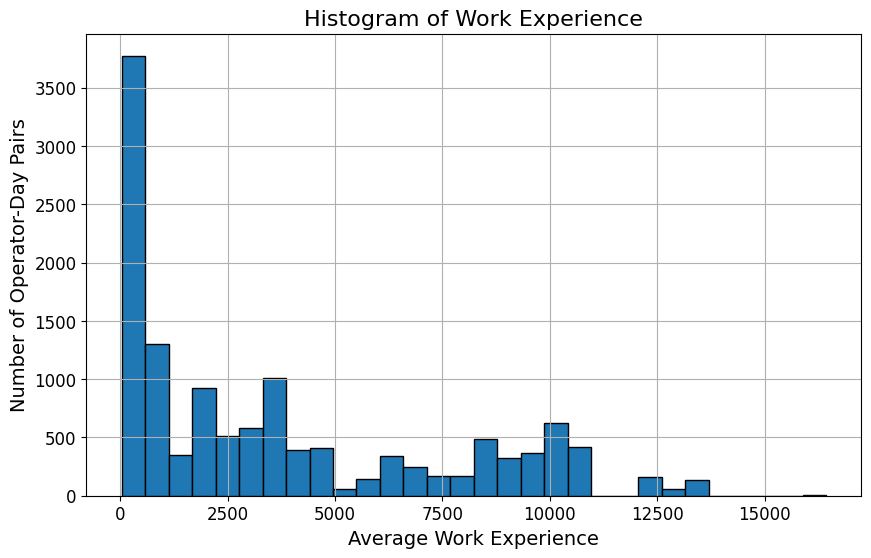

In [266]:
# Step 1: Group and collect Work_Experience values
grouped_work_exp = (
    merge1
    .groupby(['Operator2', 'CALENDAR_ID'])['Work_Experience']
    .mean()  # or use .median(), or .sum() if needed
    .reset_index()
)

# Step 2: Plot histogram of those average values
plt.figure(figsize=(10, 6))
plt.hist(grouped_work_exp['Work_Experience'], bins=30, edgecolor='black')
plt.title('Histogram of Work Experience', fontsize=16)
plt.xlabel('Average Work Experience', fontsize=14)
plt.ylabel('Number of Operator-Day Pairs', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

Most oeprators are relatively new to MARTA joining in the last 1-2 years. As we move farther on the x-axis, we see som seasoned bus drivers.

In [13]:
merge2 = merge1.merge(
    passenger_flow,
    on=['TIME_POINT_INTERVAL_ID', 'TRIP_ID', 'CALENDAR_ID'],
    how='inner',
)

merge2

,CALENDAR_ID,TRANSIT_DATE,TRIP_ID,TRIP_EDGE,PROPERTY_TAG,VEHICLE_ID,ADHERENCE,TIME_PERIOD,ROUTE_ABBR,ROUTE_DIRECTION_NAME,...,Proportion_Early,Proportion_Late,Proportion_On_Time,Work_Experience,Days_Since_Last_Coaching,Days_Since_Last_Coaching_Cat,Made_Stop_Ratio,BOARD,ALIGHT,Passenger_Activity
0,120240501,2024-05-01,9074015,0,1833,1894.0,-41.0,Before 6 AM,78,Westbound,...,0.009815,0.062548,0.927637,2809,NaN,NaN,0.400000,3.0,0.0,3.0
1,120240501,2024-05-01,9074015,0,1833,1894.0,-302.0,Before 6 AM,78,Westbound,...,0.009815,0.062548,0.927637,2809,NaN,NaN,0.600000,9.0,0.0,9.0
2,120240501,2024-05-01,9074015,2,1833,1894.0,-387.0,Before 6 AM,78,Westbound,...,0.009815,0.062548,0.927637,2809,NaN,NaN,0.300000,2.0,16.0,18.0
3,120240501,2024-05-01,9074017,0,1833,1894.0,51.0,Before 6 AM,78,Westbound,...,0.009815,0.062548,0.927637,2809,NaN,NaN,0.400000,2.0,1.0,3.0
4,120240501,2024-05-01,9074017,0,1833,1894.0,-103.0,Before 6 AM,78,Westbound,...,0.009815,0.062548,0.927637,2809,NaN,NaN,0.400000,6.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135987,120250430,2025-04-30,9548171,0,1959,2027.0,-243.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.000000,0.123060,0.876940,7485,257.0,4.0,0.250000,1.0,5.0,6.0
135988,120250430,2025-04-30,9548171,2,1959,2027.0,-16.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.000000,0.123060,0.876940,7485,257.0,4.0,0.142857,1.0,1.0,2.0
135989,120250430,2025-04-30,9548175,0,1959,2027.0,-22.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.000000,0.123060,0.876940,7485,257.0,4.0,0.222222,3.0,1.0,4.0
135990,120250430,2025-04-30,9548175,0,1959,2027.0,-208.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.000000,0.123060,0.876940,7485,257.0,4.0,0.300000,8.0,8.0,16.0


In [14]:
merge3 = merge2.merge(
    weather_data,
    left_on=['TRANSIT_DATE', 'ARRIVAL_HOUR'],
    right_on=['Date', 'Hour'],
    how='inner' 
)

merge3 = merge3.drop(columns=['Date', 'Hour'])


merge3

,CALENDAR_ID,TRANSIT_DATE,TRIP_ID,TRIP_EDGE,PROPERTY_TAG,VEHICLE_ID,ADHERENCE,TIME_PERIOD,ROUTE_ABBR,ROUTE_DIRECTION_NAME,...,Proportion_On_Time,Work_Experience,Days_Since_Last_Coaching,Days_Since_Last_Coaching_Cat,Made_Stop_Ratio,BOARD,ALIGHT,Passenger_Activity,Temperature (F),Precipitation (in)
0,120240501,2024-05-01,9074015,0,1833,1894.0,-41.0,Before 6 AM,78,Westbound,...,0.927637,2809,NaN,NaN,0.400000,3.0,0.0,3.0,56.8,0.0
1,120240501,2024-05-01,9074015,0,1833,1894.0,-302.0,Before 6 AM,78,Westbound,...,0.927637,2809,NaN,NaN,0.600000,9.0,0.0,9.0,56.8,0.0
2,120240501,2024-05-01,9074015,2,1833,1894.0,-387.0,Before 6 AM,78,Westbound,...,0.927637,2809,NaN,NaN,0.300000,2.0,16.0,18.0,56.8,0.0
3,120240501,2024-05-01,9074017,0,1833,1894.0,51.0,Before 6 AM,78,Westbound,...,0.927637,2809,NaN,NaN,0.400000,2.0,1.0,3.0,56.8,0.0
4,120240501,2024-05-01,9074017,0,1833,1894.0,-103.0,Before 6 AM,78,Westbound,...,0.927637,2809,NaN,NaN,0.400000,6.0,1.0,7.0,56.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135987,120250430,2025-04-30,9548171,0,1959,2027.0,-243.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.876940,7485,257.0,4.0,0.250000,1.0,5.0,6.0,79.3,0.0
135988,120250430,2025-04-30,9548171,2,1959,2027.0,-16.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.876940,7485,257.0,4.0,0.142857,1.0,1.0,2.0,79.3,0.0
135989,120250430,2025-04-30,9548175,0,1959,2027.0,-22.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.876940,7485,257.0,4.0,0.222222,3.0,1.0,4.0,84.2,0.0
135990,120250430,2025-04-30,9548175,0,1959,2027.0,-208.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.876940,7485,257.0,4.0,0.300000,8.0,8.0,16.0,84.2,0.0


In [15]:
# Check for PROPERTY_TAGs in tmdm_data that are not in maintenance_date['Equip. No.']
missing_property_tags = tmdm_data[~tmdm_data['PROPERTY_TAG'].isin(maintenance_data['Equip. No.'])]['PROPERTY_TAG'].unique()

if len(missing_property_tags) == 0:
    print("✅ All PROPERTY_TAGs in tmdm_data are present in maintenance_date.")
else:
    print(f"❌ The following PROPERTY_TAGs are missing from maintenance_date:\n{missing_property_tags}")



❌ The following PROPERTY_TAGs are missing from maintenance_date:
[7091]


In [16]:
merge4 = merge3.merge(
    maintenance_data,
    left_on=['PROPERTY_TAG', 'TRANSIT_DATE'],
    right_on=['Equip. No.', 'Date'],
    how='inner'
)

merge4 = merge4.drop(columns=['Equip. No.'])

merge4

,CALENDAR_ID,TRANSIT_DATE,TRIP_ID,TRIP_EDGE,PROPERTY_TAG,VEHICLE_ID,ADHERENCE,TIME_PERIOD,ROUTE_ABBR,ROUTE_DIRECTION_NAME,...,Made_Stop_Ratio,BOARD,ALIGHT,Passenger_Activity,Temperature (F),Precipitation (in),Date,Total_Symptoms,High_Severity_Symptoms,Length_of_Service
0,120240501,2024-05-01,9074015,0,1833,1894.0,-41.0,Before 6 AM,78,Westbound,...,0.400000,3.0,0.0,3.0,56.8,0.0,2024-05-01,13,9,2251
1,120240501,2024-05-01,9074015,0,1833,1894.0,-302.0,Before 6 AM,78,Westbound,...,0.600000,9.0,0.0,9.0,56.8,0.0,2024-05-01,13,9,2251
2,120240501,2024-05-01,9074015,2,1833,1894.0,-387.0,Before 6 AM,78,Westbound,...,0.300000,2.0,16.0,18.0,56.8,0.0,2024-05-01,13,9,2251
3,120240501,2024-05-01,9074017,0,1833,1894.0,51.0,Before 6 AM,78,Westbound,...,0.400000,2.0,1.0,3.0,56.8,0.0,2024-05-01,13,9,2251
4,120240501,2024-05-01,9074017,0,1833,1894.0,-103.0,Before 6 AM,78,Westbound,...,0.400000,6.0,1.0,7.0,56.8,0.0,2024-05-01,13,9,2251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136192,120250430,2025-04-30,9548171,0,1959,2027.0,-243.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.250000,1.0,5.0,6.0,79.3,0.0,2025-04-30,14,6,2192
136193,120250430,2025-04-30,9548171,2,1959,2027.0,-16.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.142857,1.0,1.0,2.0,79.3,0.0,2025-04-30,14,6,2192
136194,120250430,2025-04-30,9548175,0,1959,2027.0,-22.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.222222,3.0,1.0,4.0,84.2,0.0,2025-04-30,14,6,2192
136195,120250430,2025-04-30,9548175,0,1959,2027.0,-208.0,Midday: 9 AM to 3 PM,197,Westbound,...,0.300000,8.0,8.0,16.0,84.2,0.0,2025-04-30,14,6,2192


In [17]:
merge4.to_csv('merge4_validation.csv')

In [18]:
merged_final = pd.merge(
    merge4,
    ritis_traffic,
    on=['ROUTE_PATTERN', 'TIME_POINT_INTERVAL_ID', 'ARRIVAL_DATETIME_TRAFFIC'],
    how='inner',  # or 'inner' depending on what you want
)

merged_final

,CALENDAR_ID,TRANSIT_DATE,TRIP_ID,TRIP_EDGE,PROPERTY_TAG,VEHICLE_ID,ADHERENCE,TIME_PERIOD,ROUTE_ABBR,ROUTE_DIRECTION_NAME,...,BOARD,ALIGHT,Passenger_Activity,Temperature (F),Precipitation (in),Date,Total_Symptoms,High_Severity_Symptoms,Length_of_Service,traffic_travel_time
0,120240501,2024-05-01,9074015,0,1833,1894.0,-41.0,Before 6 AM,78,Westbound,...,3.0,0.0,3.0,56.8,0.0,2024-05-01,13,9,2251,100.440000
1,120240501,2024-05-01,9074015,0,1833,1894.0,-302.0,Before 6 AM,78,Westbound,...,9.0,0.0,9.0,56.8,0.0,2024-05-01,13,9,2251,247.683854
2,120240501,2024-05-01,9074015,2,1833,1894.0,-387.0,Before 6 AM,78,Westbound,...,2.0,16.0,18.0,56.8,0.0,2024-05-01,13,9,2251,238.217685
3,120240501,2024-05-01,9074017,0,1833,1894.0,51.0,Before 6 AM,78,Westbound,...,2.0,1.0,3.0,56.8,0.0,2024-05-01,13,9,2251,102.060000
4,120240501,2024-05-01,9074017,0,1833,1894.0,-103.0,Before 6 AM,78,Westbound,...,6.0,1.0,7.0,56.8,0.0,2024-05-01,13,9,2251,221.821346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136192,120250430,2025-04-30,9548171,0,1959,2027.0,-243.0,Midday: 9 AM to 3 PM,197,Westbound,...,1.0,5.0,6.0,79.3,0.0,2025-04-30,14,6,2192,705.227034
136193,120250430,2025-04-30,9548171,2,1959,2027.0,-16.0,Midday: 9 AM to 3 PM,197,Westbound,...,1.0,1.0,2.0,79.3,0.0,2025-04-30,14,6,2192,465.808034
136194,120250430,2025-04-30,9548175,0,1959,2027.0,-22.0,Midday: 9 AM to 3 PM,197,Westbound,...,3.0,1.0,4.0,84.2,0.0,2025-04-30,14,6,2192,386.397974
136195,120250430,2025-04-30,9548175,0,1959,2027.0,-208.0,Midday: 9 AM to 3 PM,197,Westbound,...,8.0,8.0,16.0,84.2,0.0,2025-04-30,14,6,2192,677.769167


We are analyzing intermediate bus time point stops (excluding final stops) to identify where buses most frequently do not stop at all—as indicated by identical arrival and departure times—and calculating this as a proportion of trips for each stop.

In [19]:
# Step 1: Calculate max TP_ORDER per ROUTE_PATTERN
max_tp_per_route = (
    merged_final.groupby('ROUTE_PATTERN')['TP_ORDER']
    .max()
    .reset_index()
    .rename(columns={'TP_ORDER': 'Max_TP_ORDER'})
)

# Step 2: Create a clean copy of merged_final before merging
merged_final_clean = merged_final.drop(columns=['Max_TP_ORDER'], errors='ignore').copy()

# Step 3: Merge the max TP_ORDER info into the clean copy
merged_final_clean = merged_final_clean.merge(max_tp_per_route, on='ROUTE_PATTERN', how='left')

# Step 4: Filter out rows where TP_ORDER == Max_TP_ORDER
new_df = merged_final_clean[merged_final_clean['TP_ORDER'] != merged_final_clean['Max_TP_ORDER']].copy()

# Step 5: Create Clock_Match column (arrival = departure)
new_df['Clock_Match'] = new_df['ARRIVAL_TIME_CLOCK'] == new_df['DEPARTURE_TIME_CLOCK']

# Step 6: Group by ROUTE_PATTERN and TIME_POINT_INTERVAL_ID, compute counts and proportions
summary = (
    new_df.groupby(['ROUTE_PATTERN', 'TIME_POINT_INTERVAL_ID'])
    .agg(
        Total_Count=('Clock_Match', 'count'),
        Match_Count=('Clock_Match', 'sum')
    )
    .reset_index()
)

summary['Proportion'] = summary['Match_Count'] / summary['Total_Count']

# Step 7: Display result
summary



,ROUTE_PATTERN,TIME_POINT_INTERVAL_ID,Total_Count,Match_Count,Proportion
0,140 Southbound SB,501,1958,313,0.159857
1,140 Southbound SB,1049,6411,660,0.102948
2,140 Southbound SB,1704,4453,962,0.216034
3,181 Eastbound IB,50,3556,1654,0.465129
4,181 Eastbound IB,778,4682,1213,0.259077
5,181 Eastbound IB,779,4681,2050,0.437941
6,181 Eastbound IB,780,4681,1010,0.215766
7,181 Eastbound IB,1729,1126,440,0.390764
8,181 Eastbound IB-OAK,657,4820,2086,0.432780
9,181 Eastbound IB-OAK,778,4820,1388,0.287967


In [20]:
merged_final.to_csv('merged_final.csv')

In [175]:
columns_to_drop = [
    'CALENDAR_ID',
    'TRIP_EDGE',
    'VEHICLE_ID',
    'OPERATOR_ID',
    'ONBOARD_LOGON_ID',
    'FIRST_NAME',
    'LAST_NAME',
    'TP_ORDER',
    'ARRIVAL_TIME_ROUNDED',
    'ACTIVATION_DATE',
    'DEACTIVATION_DATE',
    'In Service',
    'ROUTE_ABBR',
    'ROUTE_DIRECTION_NAME',
    'PATTERN_ABBR',
    'SCHEDULED_TIME',
    'ACTUAL_ARRIVAL_TIME',
    'ACTUAL_DEPARTURE_TIME',
    'INTERVAL_DISTANCE',
    'Coaching_DateLastSession',
    'Days_Since_Last_Coaching',
]

df_cleaned = merged_final.drop(columns=columns_to_drop, errors='ignore')
df_cleaned


,TRANSIT_DATE,TRIP_ID,PROPERTY_TAG,ADHERENCE,TIME_PERIOD,TIME_PT_NAME,SCHEDULED_TIME_CLOCK,ARRIVAL_TIME_CLOCK,DEPARTURE_TIME_CLOCK,TIMEPOINT_SEGMENT,...,BOARD,ALIGHT,Passenger_Activity,Temperature (F),Precipitation (in),Date,Total_Symptoms,High_Severity_Symptoms,Length_of_Service,traffic_travel_time
0,2024-05-01,9074015,1833,-41.0,Before 6 AM,Cleveland Ave & Browns Mill Rd,04:21:00,04:20:25,04:21:41,Jonesboro Rd & Cleveland Ave - Cleveland Ave &...,...,3.0,0.0,3.0,56.8,0.0,2024-05-01,13,9,2251,100.440000
1,2024-05-01,9074015,1833,-302.0,Before 6 AM,Cleveland Ave & Springdale Rd,04:27:00,04:31:26,04:32:02,Cleveland Ave & Browns Mill Rd - Cleveland Ave...,...,9.0,0.0,9.0,56.8,0.0,2024-05-01,13,9,2251,247.683854
2,2024-05-01,9074015,1833,-387.0,Before 6 AM,East Point Station,04:34:00,04:40:27,04:40:27,Cleveland Ave & Springdale Rd - East Point Sta...,...,2.0,16.0,18.0,56.8,0.0,2024-05-01,13,9,2251,238.217685
3,2024-05-01,9074017,1833,51.0,Before 6 AM,Cleveland Ave & Browns Mill Rd,05:01:00,04:59:20,05:00:09,Jonesboro Rd & Cleveland Ave - Cleveland Ave &...,...,2.0,1.0,3.0,56.8,0.0,2024-05-01,13,9,2251,102.060000
4,2024-05-01,9074017,1833,-103.0,Before 6 AM,Cleveland Ave & Springdale Rd,05:07:00,05:08:04,05:08:43,Cleveland Ave & Browns Mill Rd - Cleveland Ave...,...,6.0,1.0,7.0,56.8,0.0,2024-05-01,13,9,2251,221.821346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136192,2025-04-30,9548171,1959,-243.0,Midday: 9 AM to 3 PM,Battle Creek Rd & Tara Blvd,11:35:00,11:39:03,11:39:03,Mt Zion High School - Battle Creek Rd & Tara Blvd,...,1.0,5.0,6.0,79.3,0.0,2025-04-30,14,6,2192,705.227034
136193,2025-04-30,9548171,1959,-16.0,Midday: 9 AM to 3 PM,Riverdale Town Center,11:47:00,11:47:16,11:47:16,Battle Creek Rd & Tara Blvd - Riverdale Town C...,...,1.0,1.0,2.0,79.3,0.0,2025-04-30,14,6,2192,465.808034
136194,2025-04-30,9548175,1959,-22.0,Midday: 9 AM to 3 PM,Mt Zion High School,14:17:00,14:17:22,14:17:22,Davidson Pwky & Davidson Cir - Mt Zion High Sc...,...,3.0,1.0,4.0,84.2,0.0,2025-04-30,14,6,2192,386.397974
136195,2025-04-30,9548175,1959,-208.0,Midday: 9 AM to 3 PM,Battle Creek Rd & Tara Blvd,14:35:00,14:38:28,14:38:28,Mt Zion High School - Battle Creek Rd & Tara Blvd,...,8.0,8.0,16.0,84.2,0.0,2025-04-30,14,6,2192,677.769167


In [176]:
# Need to replace null values with median. Replacing with 0 would skew the results

# median_value = df_cleaned['Days_Since_Last_Coaching'].median()
# df_cleaned['Days_Since_Last_Coaching'] = df_cleaned['Days_Since_Last_Coaching'].fillna(median_value)


In [177]:
df_cleaned = df_cleaned[df_cleaned["Proportion_On_Time"].notna()]

In [178]:
df_cleaned.isnull().sum()

TRANSIT_DATE                         0
TRIP_ID                              0
PROPERTY_TAG                         0
ADHERENCE                            0
TIME_PERIOD                          0
TIME_PT_NAME                         0
SCHEDULED_TIME_CLOCK                 0
ARRIVAL_TIME_CLOCK                   0
DEPARTURE_TIME_CLOCK                 0
TIMEPOINT_SEGMENT                    0
TIME_POINT_INTERVAL_ID               0
SCHEDULED_TRAVEL_TIME                0
ACTUAL_TRAVEL_TIME_WITH_DWELL        0
COMPLETE_TRIP                        0
ARRIVAL_HOUR                         0
ARRIVAL_DATETIME_TRAFFIC             0
ROUTE_PATTERN                        0
day_of_week                          0
Operator2                            0
Coaching_SessionQuantity         95149
CALENDAR_DATE                        0
Proportion_Early                     0
Proportion_Late                      0
Proportion_On_Time                   0
Work_Experience                      0
Days_Since_Last_Coaching_

# Outlier Analysis

In [179]:
# Calculate Q1 and Q3
Q1 = df_cleaned['ACTUAL_TRAVEL_TIME_WITH_DWELL'].quantile(0.25)
Q3 = df_cleaned['ACTUAL_TRAVEL_TIME_WITH_DWELL'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_cleaned[
    (df_cleaned['ACTUAL_TRAVEL_TIME_WITH_DWELL'] < lower_bound) |
    (df_cleaned['ACTUAL_TRAVEL_TIME_WITH_DWELL'] > upper_bound)
]

print(f"Number of outliers: {len(outliers)}")


Number of outliers: 6106


In [180]:
outliers

,TRANSIT_DATE,TRIP_ID,PROPERTY_TAG,ADHERENCE,TIME_PERIOD,TIME_PT_NAME,SCHEDULED_TIME_CLOCK,ARRIVAL_TIME_CLOCK,DEPARTURE_TIME_CLOCK,TIMEPOINT_SEGMENT,...,BOARD,ALIGHT,Passenger_Activity,Temperature (F),Precipitation (in),Date,Total_Symptoms,High_Severity_Symptoms,Length_of_Service,traffic_travel_time
11,2024-05-01,9074021,1833,-973.0,AM Peak: 6 AM to 9 AM,East Point Station,06:52:00,07:08:13,07:08:13,Cleveland Ave & Springdale Rd - East Point Sta...,...,4.0,3.0,7.0,64.4,0.0,2024-05-01,13,9,2251,304.069722
14,2024-05-01,9074023,1833,-1107.0,AM Peak: 6 AM to 9 AM,East Point Station,07:52:00,08:10:27,08:10:27,Cleveland Ave & Springdale Rd - East Point Sta...,...,4.0,2.0,6.0,72.0,0.0,2024-05-01,13,9,2251,331.959892
23,2024-05-01,9074041,1833,-1037.0,PM Peak: 3 PM to 7 PM,East Point Station,16:38:00,16:55:17,16:55:17,Cleveland Ave & Springdale Rd - East Point Sta...,...,2.0,0.0,2.0,82.8,0.0,2024-05-01,13,9,2251,292.824816
31,2024-05-01,9080159,1822,-858.0,PM Peak: 3 PM to 7 PM,Battle Creek Rd & Tara Blvd,17:28:00,17:41:42,17:42:18,Mt Zion High School - Battle Creek Rd & Tara Blvd,...,1.0,1.0,2.0,82.6,0.0,2024-05-01,10,3,2263,720.632059
44,2024-05-01,9080426,1887,-1172.0,PM Peak: 3 PM to 7 PM,West End Station,16:11:00,16:30:32,16:30:32,Georgia Ave & Hill St - West End Station,...,5.0,1.0,6.0,82.8,0.0,2024-05-01,12,2,2083,542.239290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136168,2025-04-30,9542649,1883,-232.0,Night: After 9 PM,Battle Creek Rd & Tara Blvd,21:34:00,21:37:52,21:37:52,Mt Zion High School - Battle Creek Rd & Tara Blvd,...,0.0,0.0,0.0,73.0,0.0,2025-04-30,12,5,2547,529.457917
136174,2025-04-30,9542656,1883,-396.0,AM Peak: 6 AM to 9 AM,Battle Creek Rd & Tara Blvd,07:32:00,07:38:36,07:38:36,Mt Zion High School - Battle Creek Rd & Tara Blvd,...,0.0,0.0,0.0,69.6,0.0,2025-04-30,12,5,2547,754.504877
136180,2025-04-30,9542664,1883,-280.0,Midday: 9 AM to 3 PM,Battle Creek Rd & Tara Blvd,13:35:00,13:39:40,13:39:40,Mt Zion High School - Battle Creek Rd & Tara Blvd,...,0.0,0.0,0.0,82.9,0.0,2025-04-30,12,5,2547,718.404632
136189,2025-04-30,9548167,1959,-450.0,AM Peak: 6 AM to 9 AM,Battle Creek Rd & Tara Blvd,08:32:00,08:38:51,08:39:30,Mt Zion High School - Battle Creek Rd & Tara Blvd,...,7.0,5.0,12.0,72.1,0.0,2025-04-30,14,6,2192,660.227843


C:\Users\ksomu-ctr\AppData\Local\Temp\ipykernel_14828\3094134986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['TIME_POINT_INTERVAL_ID'] = outliers['TIME_POINT_INTERVAL_ID'].astype(str)


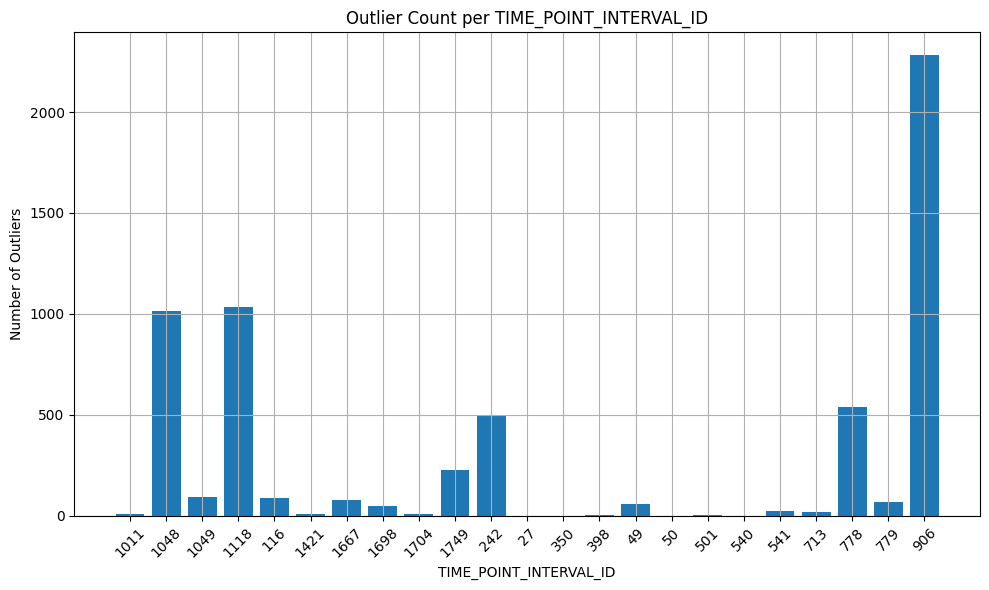

In [181]:
outliers['TIME_POINT_INTERVAL_ID'] = outliers['TIME_POINT_INTERVAL_ID'].astype(str)

outlier_distribution = outliers['TIME_POINT_INTERVAL_ID'].value_counts().sort_index()

# Step 4 (Optional): Display as DataFrame
outlier_distribution_df = outlier_distribution.reset_index()
outlier_distribution_df.columns = ['TIME_POINT_INTERVAL_ID', 'Outlier_Count']

plt.figure(figsize=(10, 6))
plt.bar(outlier_distribution_df['TIME_POINT_INTERVAL_ID'], outlier_distribution_df['Outlier_Count'])
plt.title('Outlier Count per TIME_POINT_INTERVAL_ID')
plt.xlabel('TIME_POINT_INTERVAL_ID')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

While some timepoints show small number of outliers, there are timepoints where outliers seem to be a pattern more so than extreme points.

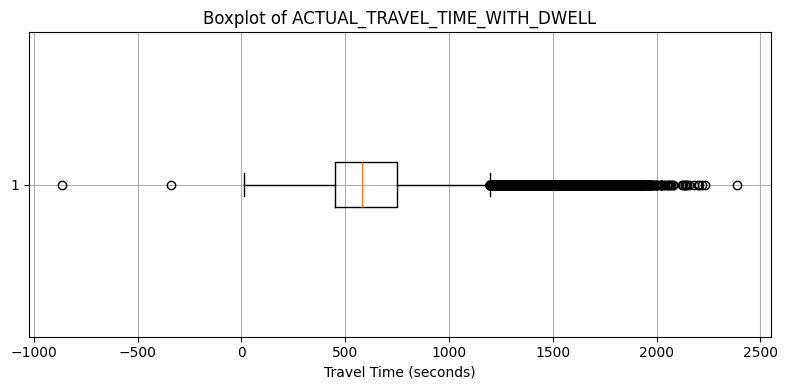

In [182]:
plt.figure(figsize=(8, 4))
plt.boxplot(df_cleaned['ACTUAL_TRAVEL_TIME_WITH_DWELL'].dropna(), vert=False)
plt.title('Boxplot of ACTUAL_TRAVEL_TIME_WITH_DWELL')
plt.xlabel('Travel Time (seconds)')
plt.grid(True)
plt.tight_layout()
plt.show()

Appears outliers tend to be on the higher end of travel time than the lower end.

In [183]:
# Ensure TIME_POINT_INTERVAL_ID is string (optional, if desired for readability)
df_cleaned['TIME_POINT_INTERVAL_ID'] = df_cleaned['TIME_POINT_INTERVAL_ID'].astype(str)

# Group and calculate mean
avg_travel_time_by_interval = (
    df_cleaned.groupby('TIME_POINT_INTERVAL_ID')['ACTUAL_TRAVEL_TIME_WITH_DWELL']
    .mean()
    .reset_index(name='Average_Travel_Time')
)

# Sort by interval (optional)
avg_travel_time_by_interval = avg_travel_time_by_interval.sort_values('TIME_POINT_INTERVAL_ID')

# View result
avg_travel_time_by_interval


C:\Users\ksomu-ctr\AppData\Local\Temp\ipykernel_14828\3250996703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['TIME_POINT_INTERVAL_ID'] = df_cleaned['TIME_POINT_INTERVAL_ID'].astype(str)


,TIME_POINT_INTERVAL_ID,Average_Travel_Time
0,1011,610.207043
1,1048,715.396873
2,1049,822.853525
3,1118,1105.707400
4,116,551.114524
5,1421,789.092551
6,1667,775.581164
7,1698,669.638682
8,1704,310.336560
9,1729,589.424377


Good to compare certain predictions for a timepoint against their average travel time. Please refer to this table when analyzing individual SHAP predictions.

In [184]:
def detect_outliers_with_bounds(group):
    q1 = group['ACTUAL_TRAVEL_TIME_WITH_DWELL'].quantile(0.25)
    q3 = group['ACTUAL_TRAVEL_TIME_WITH_DWELL'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    group['Is_Outlier'] = (group['ACTUAL_TRAVEL_TIME_WITH_DWELL'] < lower) | (group['ACTUAL_TRAVEL_TIME_WITH_DWELL'] > upper)
    group['Upper_Bound'] = upper
    group['Lower_Bound'] = lower
    return group


df_outliers_by_timepoint = (
    df_cleaned
    .groupby('TIME_POINT_INTERVAL_ID')
    .apply(detect_outliers_with_bounds)
    .reset_index(drop=True)  # fixes the ambiguity
)


outlier_counts = (
    df_outliers_by_timepoint[df_outliers_by_timepoint['Is_Outlier']]
    .groupby('TIME_POINT_INTERVAL_ID')
    .size()
    .reset_index(name='Outlier_Count')
)

df_outliers_by_timepoint[df_outliers_by_timepoint['TIME_POINT_INTERVAL_ID']=='1048']


C:\Users\ksomu-ctr\AppData\Local\Temp\ipykernel_14828\1534931566.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_outliers_with_bounds)


,TRANSIT_DATE,TRIP_ID,PROPERTY_TAG,ADHERENCE,TIME_PERIOD,TIME_PT_NAME,SCHEDULED_TIME_CLOCK,ARRIVAL_TIME_CLOCK,DEPARTURE_TIME_CLOCK,TIMEPOINT_SEGMENT,...,Temperature (F),Precipitation (in),Date,Total_Symptoms,High_Severity_Symptoms,Length_of_Service,traffic_travel_time,Is_Outlier,Upper_Bound,Lower_Bound
5168,2024-05-01,9085072,7089,308.0,PM Peak: 3 PM to 7 PM,North Springs Station,18:35:00,18:29:52,18:29:52,Mansell Park & Ride - North Springs Station,...,79.0,0.0,2024-05-01,2,0,819,434.262435,False,1234.5,-17.5
5169,2024-05-01,9085076,7089,-109.0,Night: After 9 PM,North Springs Station,21:55:00,21:56:49,21:56:49,Mansell Park & Ride - North Springs Station,...,68.2,0.0,2024-05-01,2,0,819,436.366422,False,1234.5,-17.5
5170,2024-05-01,9085081,7005,-2.0,AM Peak: 6 AM to 9 AM,North Springs Station,07:15:00,07:15:02,07:15:02,Mansell Park & Ride - North Springs Station,...,64.4,0.0,2024-05-01,2,0,1804,672.914121,False,1234.5,-17.5
5171,2024-05-01,9085085,7005,274.0,Midday: 9 AM to 3 PM,North Springs Station,10:35:00,10:30:26,10:30:26,Mansell Park & Ride - North Springs Station,...,77.0,0.0,2024-05-01,2,0,1804,522.465731,False,1234.5,-17.5
5172,2024-05-01,9085089,7005,245.0,Midday: 9 AM to 3 PM,North Springs Station,13:55:00,13:50:02,13:50:55,Mansell Park & Ride - North Springs Station,...,81.9,0.0,2024-05-01,2,0,1804,427.750025,False,1234.5,-17.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11558,2025-04-30,9530950,7007,-141.0,Midday: 9 AM to 3 PM,North Springs Station,12:35:00,12:32:36,12:37:21,Mansell Park & Ride - North Springs Station,...,81.5,0.0,2025-04-30,5,1,2153,407.510010,False,1234.5,-17.5
11559,2025-04-30,9541013,7020,-350.0,PM Peak: 3 PM to 7 PM,North Springs Station,17:55:00,18:00:50,18:00:50,Mansell Park & Ride - North Springs Station,...,80.1,0.0,2025-04-30,10,2,2153,468.340843,False,1234.5,-17.5
11560,2025-04-30,9541017,7020,339.0,Evening: 7 PM to 9 PM,North Springs Station,21:15:00,21:09:21,21:09:21,Mansell Park & Ride - North Springs Station,...,73.0,0.0,2025-04-30,10,2,2153,424.335167,False,1234.5,-17.5
11561,2025-04-30,9546124,7015,129.0,PM Peak: 3 PM to 7 PM,North Springs Station,15:55:00,15:52:51,15:52:51,Mansell Park & Ride - North Springs Station,...,82.8,0.0,2025-04-30,9,1,2160,421.578148,False,1234.5,-17.5


Counts the outliers for each timepoint based on IQR method.

In [185]:
timepoint_counts = (
    df_cleaned
    .groupby('TIME_POINT_INTERVAL_ID')
    .size()
    .reset_index(name='Record_Count')
)

timepoint_counts

,TIME_POINT_INTERVAL_ID,Record_Count
0,1011,5168
1,1048,6395
2,1049,6397
3,1118,3838
4,116,4558
5,1421,443
6,1667,4725
7,1698,3216
8,1704,4442
9,1729,1124


In [186]:
outlier_summary = (
    df_outliers_by_timepoint
    .groupby('TIME_POINT_INTERVAL_ID')
    .agg(
        Record_Count=('ACTUAL_TRAVEL_TIME_WITH_DWELL', 'count'),
        Outlier_Count=('Is_Outlier', 'sum')
    )
    .reset_index()
)
outlier_summary['Outlier_Rate'] = outlier_summary['Outlier_Count'] / outlier_summary['Record_Count']

outlier_summary


,TIME_POINT_INTERVAL_ID,Record_Count,Outlier_Count,Outlier_Rate
0,1011,5168,91,0.017608
1,1048,6395,981,0.153401
2,1049,6397,221,0.034547
3,1118,3838,77,0.020063
4,116,4558,378,0.082931
5,1421,443,17,0.038375
6,1667,4725,167,0.035344
7,1698,3216,128,0.039801
8,1704,4442,340,0.076542
9,1729,1124,26,0.023132


In [187]:
# filtered_data = df_cleaned[df_cleaned['TIME_POINT_INTERVAL_ID']=='779']

# plt.figure(figsize=(10, 6))
# plt.hist(filtered_data['ACTUAL_TRAVEL_TIME_WITH_DWELL'], bins=20, edgecolor='black')
# plt.title('Histogram of travel time')
# plt.xlabel('Travel Time')
# plt.ylabel('Number of trips')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()


In [ ]:
# E.g., keep outliers only if outlier rate >= 5%
high_variance_intervals = outlier_summary[outlier_summary['Outlier_Rate'] >= 0.05]['TIME_POINT_INTERVAL_ID']
high_variance_intervals

1     1048
4      116
8     1704
14     398
17     501
22     778
Name: TIME_POINT_INTERVAL_ID, dtype: object

The above counts the percentage of data that is outliers by timepoint segment. For timepoints with high percentage of outliers, we will not exclude those datapoints in the model since they may reflect meaningful patterns.

In [ ]:
#df_outliers_by_timepoint.to_csv('outlier_analysis.csv')

In [190]:
filtered_df = df_outliers_by_timepoint[
    (~df_outliers_by_timepoint['Is_Outlier']) | 
    (df_outliers_by_timepoint['TIME_POINT_INTERVAL_ID'].isin(high_variance_intervals))
]

#Remove Negative Travel Time Values
filtered_df = filtered_df[filtered_df['ACTUAL_TRAVEL_TIME_WITH_DWELL'] >= 0]

filtered_df

,TRANSIT_DATE,TRIP_ID,PROPERTY_TAG,ADHERENCE,TIME_PERIOD,TIME_PT_NAME,SCHEDULED_TIME_CLOCK,ARRIVAL_TIME_CLOCK,DEPARTURE_TIME_CLOCK,TIMEPOINT_SEGMENT,...,Temperature (F),Precipitation (in),Date,Total_Symptoms,High_Severity_Symptoms,Length_of_Service,traffic_travel_time,Is_Outlier,Upper_Bound,Lower_Bound
0,2024-05-01,9080404,1887,-61.0,Before 6 AM,West End Station,05:04:00,05:05:01,05:05:01,Georgia Ave & Hill St - West End Station,...,56.8,0.0,2024-05-01,12,2,2083,350.820942,False,870.5,338.5
1,2024-05-01,9080418,1887,-281.0,Midday: 9 AM to 3 PM,West End Station,12:07:00,12:11:41,12:11:41,Georgia Ave & Hill St - West End Station,...,79.3,0.0,2024-05-01,12,2,2083,481.672100,False,870.5,338.5
3,2024-05-01,9080432,1887,-857.0,PM Peak: 3 PM to 7 PM,West End Station,19:05:00,19:19:17,19:19:17,Georgia Ave & Hill St - West End Station,...,76.8,0.0,2024-05-01,12,2,2083,540.364087,False,870.5,338.5
4,2024-05-02,9080404,1951,-316.0,Before 6 AM,West End Station,05:04:00,05:09:16,05:09:16,Georgia Ave & Hill St - West End Station,...,58.5,0.0,2024-05-02,14,4,1847,345.620942,False,870.5,338.5
5,2024-05-02,9080406,1951,-298.0,Before 6 AM,West End Station,05:59:00,06:03:58,06:03:58,Georgia Ave & Hill St - West End Station,...,61.0,0.0,2024-05-02,14,4,1847,345.941287,False,870.5,338.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135829,2025-04-30,9524830,7027,-1138.0,AM Peak: 6 AM to 9 AM,East Point Station,07:37:00,07:55:58,07:55:58,Cleveland Ave & Springdale Rd - East Point Sta...,...,69.6,0.0,2025-04-30,7,4,2076,326.937430,False,2462.0,-642.0
135830,2025-04-30,9524832,7027,-235.0,AM Peak: 6 AM to 9 AM,East Point Station,08:37:00,08:40:55,08:40:55,Cleveland Ave & Springdale Rd - East Point Sta...,...,72.1,0.0,2025-04-30,7,4,2076,308.121864,False,2462.0,-642.0
135831,2025-04-30,9540362,1408,-1165.0,PM Peak: 3 PM to 7 PM,East Point Station,16:07:00,16:26:25,16:26:25,Cleveland Ave & Springdale Rd - East Point Sta...,...,83.5,0.0,2025-04-30,20,4,4033,332.666170,False,2462.0,-642.0
135832,2025-04-30,9540364,1408,-1091.0,PM Peak: 3 PM to 7 PM,East Point Station,17:08:00,17:26:11,17:26:11,Cleveland Ave & Springdale Rd - East Point Sta...,...,82.9,0.0,2025-04-30,20,4,4033,304.704254,False,2462.0,-642.0


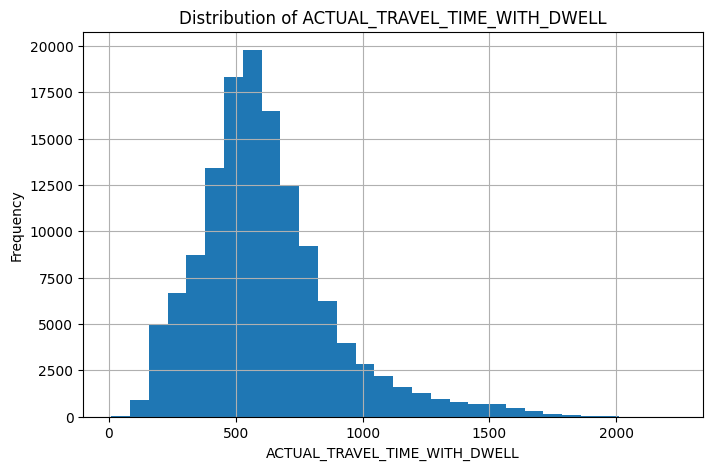

Skewness: 1.1873
Kurtosis: 2.3577


In [191]:
# 1. Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(filtered_df['ACTUAL_TRAVEL_TIME_WITH_DWELL'].dropna(), bins=30)
plt.title('Distribution of ACTUAL_TRAVEL_TIME_WITH_DWELL')
plt.xlabel('ACTUAL_TRAVEL_TIME_WITH_DWELL')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Compute skew and kurtosis
skewness = filtered_df['ACTUAL_TRAVEL_TIME_WITH_DWELL'].skew()
kurtosis = filtered_df['ACTUAL_TRAVEL_TIME_WITH_DWELL'].kurtosis()

print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")


Next I will look at the outliers for passenger activity since we see heavy skewness for this variable. I will follow the same approach I used for evaluating outliers for travel time.

In [192]:
# Ensure TIME_POINT_INTERVAL_ID is string (optional, if desired for readability)
filtered_df['TIME_POINT_INTERVAL_ID'] = filtered_df['TIME_POINT_INTERVAL_ID'].astype(str)

# Group and calculate mean
avg_passenger_activity_by_interval = (
    filtered_df.groupby('TIME_POINT_INTERVAL_ID')['Passenger_Activity']
    .mean()
    .reset_index(name='Average_Passenger_Activity')
)

# Sort by interval (optional)
avg_passenger_activity_by_interval = avg_passenger_activity_by_interval.sort_values('TIME_POINT_INTERVAL_ID')

# View result
avg_passenger_activity_by_interval

,TIME_POINT_INTERVAL_ID,Average_Passenger_Activity
0,1011,2.051014
1,1048,0.227209
2,1049,3.440738
3,1118,6.429939
4,116,2.253839
5,1421,2.424883
6,1667,3.253620
7,1698,3.938472
8,1704,0.755741
9,1729,5.997268


In [193]:
def detect_outliers_passenger_activity(group):
    q1 = group['Passenger_Activity'].quantile(0.25)
    q3 = group['Passenger_Activity'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    group['Is_Outlier_Passenger'] = (group['Passenger_Activity'] < lower) | (group['Passenger_Activity'] > upper)
    group['Upper_Bound_Passenger'] = upper
    group['Lower_Bound_Passenger'] = lower
    return group

df_outliers_passenger = (
    filtered_df
    .groupby('TIME_POINT_INTERVAL_ID')
    .apply(detect_outliers_passenger_activity)
    .reset_index(drop=True)
)

passenger_outlier_counts = (
    df_outliers_passenger[df_outliers_passenger['Is_Outlier_Passenger']]
    .groupby('TIME_POINT_INTERVAL_ID')
    .size()
    .reset_index(name='Passenger_Activity_Outlier_Count')
)



C:\Users\ksomu-ctr\AppData\Local\Temp\ipykernel_14828\3778017385.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_outliers_passenger_activity)


In [194]:
timepoint_counts = (
    filtered_df
    .groupby('TIME_POINT_INTERVAL_ID')
    .size()
    .reset_index(name='Record_Count')
)

timepoint_counts

,TIME_POINT_INTERVAL_ID,Record_Count
0,1011,5077
1,1048,6395
2,1049,6176
3,1118,3761
4,116,4558
5,1421,426
6,1667,4558
7,1698,3088
8,1704,4442
9,1729,1098


In [195]:
df_outliers_passenger

,TRANSIT_DATE,TRIP_ID,PROPERTY_TAG,ADHERENCE,TIME_PERIOD,TIME_PT_NAME,SCHEDULED_TIME_CLOCK,ARRIVAL_TIME_CLOCK,DEPARTURE_TIME_CLOCK,TIMEPOINT_SEGMENT,...,Total_Symptoms,High_Severity_Symptoms,Length_of_Service,traffic_travel_time,Is_Outlier,Upper_Bound,Lower_Bound,Is_Outlier_Passenger,Upper_Bound_Passenger,Lower_Bound_Passenger
0,2024-05-01,9080404,1887,-61.0,Before 6 AM,West End Station,05:04:00,05:05:01,05:05:01,Georgia Ave & Hill St - West End Station,...,12,2,2083,350.820942,False,870.5,338.5,False,7.5,-4.5
1,2024-05-01,9080418,1887,-281.0,Midday: 9 AM to 3 PM,West End Station,12:07:00,12:11:41,12:11:41,Georgia Ave & Hill St - West End Station,...,12,2,2083,481.672100,False,870.5,338.5,False,7.5,-4.5
2,2024-05-01,9080432,1887,-857.0,PM Peak: 3 PM to 7 PM,West End Station,19:05:00,19:19:17,19:19:17,Georgia Ave & Hill St - West End Station,...,12,2,2083,540.364087,False,870.5,338.5,False,7.5,-4.5
3,2024-05-02,9080404,1951,-316.0,Before 6 AM,West End Station,05:04:00,05:09:16,05:09:16,Georgia Ave & Hill St - West End Station,...,14,4,1847,345.620942,False,870.5,338.5,False,7.5,-4.5
4,2024-05-02,9080406,1951,-298.0,Before 6 AM,West End Station,05:59:00,06:03:58,06:03:58,Georgia Ave & Hill St - West End Station,...,14,4,1847,345.941287,False,870.5,338.5,False,7.5,-4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133286,2025-04-30,9524830,7027,-1138.0,AM Peak: 6 AM to 9 AM,East Point Station,07:37:00,07:55:58,07:55:58,Cleveland Ave & Springdale Rd - East Point Sta...,...,7,4,2076,326.937430,False,2462.0,-642.0,False,18.5,-9.5
133287,2025-04-30,9524832,7027,-235.0,AM Peak: 6 AM to 9 AM,East Point Station,08:37:00,08:40:55,08:40:55,Cleveland Ave & Springdale Rd - East Point Sta...,...,7,4,2076,308.121864,False,2462.0,-642.0,False,18.5,-9.5
133288,2025-04-30,9540362,1408,-1165.0,PM Peak: 3 PM to 7 PM,East Point Station,16:07:00,16:26:25,16:26:25,Cleveland Ave & Springdale Rd - East Point Sta...,...,20,4,4033,332.666170,False,2462.0,-642.0,False,18.5,-9.5
133289,2025-04-30,9540364,1408,-1091.0,PM Peak: 3 PM to 7 PM,East Point Station,17:08:00,17:26:11,17:26:11,Cleveland Ave & Springdale Rd - East Point Sta...,...,20,4,4033,304.704254,False,2462.0,-642.0,False,18.5,-9.5


In [196]:
outlier_summary = (
    df_outliers_passenger
    .groupby('TIME_POINT_INTERVAL_ID')
    .agg(
        Record_Count=('Passenger_Activity', 'count'),
        Outlier_Count=('Is_Outlier_Passenger', 'sum')
    )
    .reset_index()
)
outlier_summary['Outlier_Rate_Passenger'] = outlier_summary['Outlier_Count'] / outlier_summary['Record_Count']

outlier_summary


,TIME_POINT_INTERVAL_ID,Record_Count,Outlier_Count,Outlier_Rate_Passenger
0,1011,5077,186,0.036636
1,1048,6395,277,0.043315
2,1049,6176,236,0.038212
3,1118,3761,85,0.022600
4,116,4558,166,0.036419
5,1421,426,10,0.023474
6,1667,4558,73,0.016016
7,1698,3088,48,0.015544
8,1704,4442,385,0.086673
9,1729,1098,10,0.009107


In [197]:
high_variance_intervals_passenger = outlier_summary[outlier_summary['Outlier_Rate_Passenger'] >= 0.05]['TIME_POINT_INTERVAL_ID']
high_variance_intervals_passenger

8     1704
15      49
17     501
Name: TIME_POINT_INTERVAL_ID, dtype: object

In [198]:
filtered_df = df_outliers_passenger[
    (~df_outliers_passenger['Is_Outlier_Passenger']) #| 
    #(df_outliers_passenger['TIME_POINT_INTERVAL_ID'].isin(high_variance_intervals_passenger))
]

filtered_df

,TRANSIT_DATE,TRIP_ID,PROPERTY_TAG,ADHERENCE,TIME_PERIOD,TIME_PT_NAME,SCHEDULED_TIME_CLOCK,ARRIVAL_TIME_CLOCK,DEPARTURE_TIME_CLOCK,TIMEPOINT_SEGMENT,...,Total_Symptoms,High_Severity_Symptoms,Length_of_Service,traffic_travel_time,Is_Outlier,Upper_Bound,Lower_Bound,Is_Outlier_Passenger,Upper_Bound_Passenger,Lower_Bound_Passenger
0,2024-05-01,9080404,1887,-61.0,Before 6 AM,West End Station,05:04:00,05:05:01,05:05:01,Georgia Ave & Hill St - West End Station,...,12,2,2083,350.820942,False,870.5,338.5,False,7.5,-4.5
1,2024-05-01,9080418,1887,-281.0,Midday: 9 AM to 3 PM,West End Station,12:07:00,12:11:41,12:11:41,Georgia Ave & Hill St - West End Station,...,12,2,2083,481.672100,False,870.5,338.5,False,7.5,-4.5
2,2024-05-01,9080432,1887,-857.0,PM Peak: 3 PM to 7 PM,West End Station,19:05:00,19:19:17,19:19:17,Georgia Ave & Hill St - West End Station,...,12,2,2083,540.364087,False,870.5,338.5,False,7.5,-4.5
3,2024-05-02,9080404,1951,-316.0,Before 6 AM,West End Station,05:04:00,05:09:16,05:09:16,Georgia Ave & Hill St - West End Station,...,14,4,1847,345.620942,False,870.5,338.5,False,7.5,-4.5
4,2024-05-02,9080406,1951,-298.0,Before 6 AM,West End Station,05:59:00,06:03:58,06:03:58,Georgia Ave & Hill St - West End Station,...,14,4,1847,345.941287,False,870.5,338.5,False,7.5,-4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133286,2025-04-30,9524830,7027,-1138.0,AM Peak: 6 AM to 9 AM,East Point Station,07:37:00,07:55:58,07:55:58,Cleveland Ave & Springdale Rd - East Point Sta...,...,7,4,2076,326.937430,False,2462.0,-642.0,False,18.5,-9.5
133287,2025-04-30,9524832,7027,-235.0,AM Peak: 6 AM to 9 AM,East Point Station,08:37:00,08:40:55,08:40:55,Cleveland Ave & Springdale Rd - East Point Sta...,...,7,4,2076,308.121864,False,2462.0,-642.0,False,18.5,-9.5
133288,2025-04-30,9540362,1408,-1165.0,PM Peak: 3 PM to 7 PM,East Point Station,16:07:00,16:26:25,16:26:25,Cleveland Ave & Springdale Rd - East Point Sta...,...,20,4,4033,332.666170,False,2462.0,-642.0,False,18.5,-9.5
133289,2025-04-30,9540364,1408,-1091.0,PM Peak: 3 PM to 7 PM,East Point Station,17:08:00,17:26:11,17:26:11,Cleveland Ave & Springdale Rd - East Point Sta...,...,20,4,4033,304.704254,False,2462.0,-642.0,False,18.5,-9.5


I ended up removing all the outliers for passenger activity.

In [199]:
rename_map = {
    'Coaching_SessionQuantity': 'Coaching_Sessions',
    'Proportion_On_Time': 'On_Time_Rate',
    'Days_Since_Last_Coaching_Cat': 'Days_Since_Last_Coaching',
    'Work_Experience': 'Work_Experience_Days',
    'Made_Stop_Ratio': 'Made_Stop_Ratio',
    'Passenger_Activity': 'Passenger_Activity',
    'Temperature (F)': 'Temperature',
    'Precipitation (in)': 'Precipitation',
    'Total_Symptoms': 'Total_Symptoms',
    'High_Severity_Symptoms': 'Severe_Symptoms',
    'Length_of_Service': 'Service_Length_Days',
    'traffic_travel_time': 'Traffic_Travel_Time',
    'ROUTE_PATTERN': 'Route_Pattern',
    'TIME_POINT_INTERVAL_ID': 'Time_Point_Segment',
    'TIME_PERIOD': 'Time_Period',
    'day_of_week': 'Day_of_Week'
}

filtered_df = filtered_df.rename(columns=rename_map)


In [200]:
filtered_df.to_csv('df_cleaned.csv',index=False)

# Model Building

In [267]:
predictors = [
    'Coaching_Sessions', 
    'On_Time_Rate',
    'Days_Since_Last_Coaching',
    'Work_Experience_Days',
    'Made_Stop_Ratio',
    'Passenger_Activity',
    'Temperature',
    'Precipitation',
    'Total_Symptoms',
    'Severe_Symptoms',
    'Service_Length_Days',
    'Traffic_Travel_Time',
    'Time_Point_Segment'
    #'Time_Period',
    #'Day_of_Week'
]


target = 'ACTUAL_TRAVEL_TIME_WITH_DWELL'

# Create feature and target sets
X = filtered_df[predictors].copy()
y = filtered_df[target]




In [268]:
# Mapping Timepoints to categorical variables

timepoint_equivalence = {
    "1704": "501",
    "1729": "50",
    "1749": "1118",
    "713": "1698",
    "1421": "1667"
}

X["Time_Point_Segment"] = X["Time_Point_Segment"].astype(str)  # Ensure consistent type
X["Time_Point_Segment"] = X["Time_Point_Segment"].replace(timepoint_equivalence)


# Save the categorical version first
timepoint_cat = X["Time_Point_Segment"].astype("category")

# Now get the mapping
category_mapping = dict(enumerate(timepoint_cat.cat.categories))
category_mapping


{0: '1011',
 1: '1048',
 2: '1049',
 3: '1118',
 4: '116',
 5: '1667',
 6: '1698',
 7: '242',
 8: '27',
 9: '350',
 10: '398',
 11: '49',
 12: '50',
 13: '501',
 14: '540',
 15: '541',
 16: '657',
 17: '778',
 18: '779',
 19: '780',
 20: '906'}

Some of the timepoints were the same they just had different ids at different dates in the period of study. To improve interpretability and ensure the model treated these as a single consistent location, I consolidated them into one unified timepoint.

In [269]:
#Categorical Variables
X['Time_Point_Segment'] = X["Time_Point_Segment"].astype("category").cat.codes
#X['Time_Period'] = X["Time_Period"].astype("category").cat.codes
#X['Day_of_Week'] = X["Day_of_Week"].astype("category").cat.codes
X['Days_Since_Last_Coaching'] = X['Days_Since_Last_Coaching'].astype('category').cat.codes

In [270]:
# Experiment 2 Log Transformations and Interaction Variables

# X["Log_Passenger_Activity"] = np.log1p(X["Passenger_Activity"])
# X["Stop_x_Passenger"] = X["Made_Stop_Ratio"] * X["Passenger_Activity"]
# X["Route_x_Traffic"] = X["Route_Pattern"] * X["Traffic_Travel_Time"]
# X["Route_x_StopRatio"] = X["Route_Pattern"] * X["Made_Stop_Ratio"]
# X["Route_x_Passenger"] = X["Route_Pattern"] * X["Passenger_Activity"]

In [271]:
# route_pattern_mapping = dict(enumerate(filtered_df['Route_Pattern'].astype('category').cat.categories))
# route_pattern_mapping

In [272]:
# Step 1: First split off the test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Step 2: Now split the remaining 90% into 70% train and 20% val
# Since X_temp is 90% of data, 20% out of the full dataset = ~22.2% of X_temp
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=2/9, random_state=42)  # 2/9 ≈ 22.2%

In [274]:
mean_values = X_test.mean()
mean_values

Coaching_Sessions              2.315033
On_Time_Rate                   0.803751
Days_Since_Last_Coaching       0.054180
Work_Experience_Days        3664.312350
Made_Stop_Ratio                0.170101
Passenger_Activity             3.776139
Temperature                   65.641574
Precipitation                  0.004873
Total_Symptoms                14.018552
Severe_Symptoms                4.241171
Service_Length_Days         2342.552666
Traffic_Travel_Time          386.682585
Time_Point_Segment            10.767523
dtype: float64

# Model Skew Analysis

In [ ]:
num_predictors = [
    'Coaching_Sessions', 
    'On_Time_Rate',
    'Work_Experience_Days',
    'Made_Stop_Ratio',
    'Passenger_Activity',
    'Temperature',
    'Precipitation',
    'Total_Symptoms',
    'Severe_Symptoms',
    'Service_Length_Days',
    'Traffic_Travel_Time',
   # 'Log_Passenger_Activity',
   # 'Stop_x_Passenger',
   # 'Route_x_Traffic',
   # 'Route_x_StopRatio',
   # 'Route_x_Passenger'
]
for col in num_predictors:
    plt.figure(figsize=(6, 4))
    plt.hist(X[col].dropna(), bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [276]:
print(X[num_predictors].skew())
print(X[num_predictors].kurtosis())


Coaching_Sessions       4.036880
On_Time_Rate           -1.314468
Work_Experience_Days    0.909208
Made_Stop_Ratio         0.967459
Passenger_Activity      1.608161
Temperature            -0.515794
Precipitation           9.008796
Total_Symptoms          1.134712
Severe_Symptoms         2.101903
Service_Length_Days    -0.183724
Traffic_Travel_Time     0.106863
dtype: float64
Coaching_Sessions        21.733676
On_Time_Rate              2.783311
Work_Experience_Days     -0.396841
Made_Stop_Ratio           0.703222
Passenger_Activity        3.260545
Temperature              -0.475727
Precipitation           101.751929
Total_Symptoms            1.692825
Severe_Symptoms           7.091997
Service_Length_Days       0.147195
Traffic_Travel_Time       0.787367
dtype: float64


Wanted to evaluate the skew of variables to see if log transformations could improve the model.

# XG Boost

In [281]:
# Initialize the model


xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=700,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=10,
    subsample=1.0,
    colsample_bytree=.707,
    gamma=0,
    reg_alpha = 1.0,
    reg_lambda=1.0,
    eval_metric='rmse',
    early_stopping_rounds=50,
    random_state=42
)


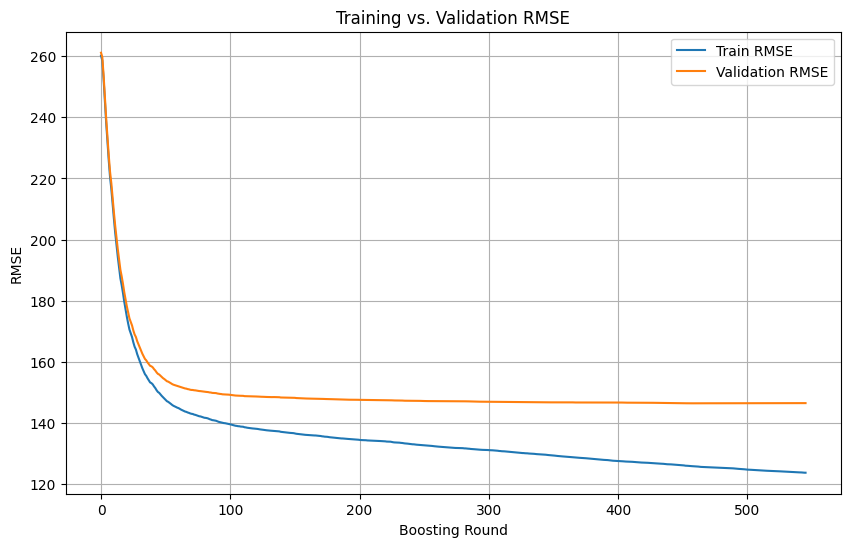

In [282]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

results = xgb_model.evals_result()

# Plot training and validation RMSE
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Training vs. Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

Loss curve shows that while the training data continues to improve the validation levels off closer to the 100th boosting round. The early stopping ensures we dont go pass the ~550 mark since the number of rounds that the hyperparameter tuning suggested was 700.

In [283]:
val_preds = xgb_model.predict(X_val)
val_r2 = r2_score(y_val, val_preds)

print(f"Validation R²: {val_r2:.4f}")

Validation R²: 0.7041


In [284]:
# Predict on test set
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test R² Score: {r2:.4f}")

Test MAE: 88.38
Test RMSE: 144.03
Test MAPE: 14.71%
Test R² Score: 0.7222


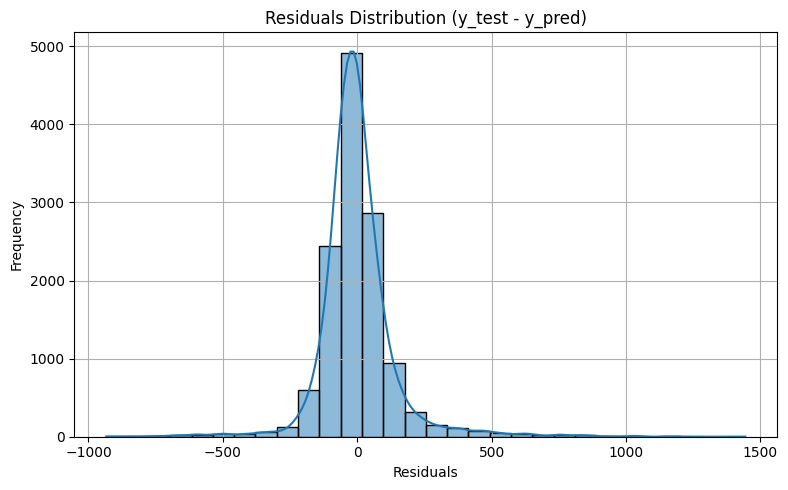

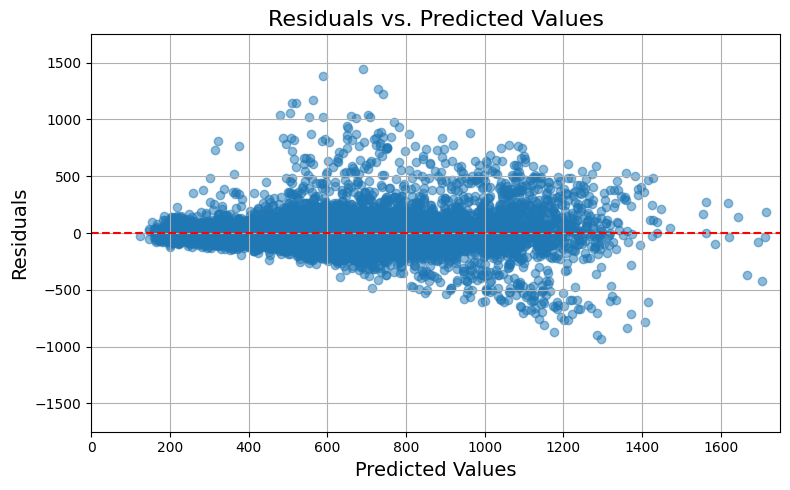

In [295]:
# Calculate residuals
residuals = y_test - y_pred

# Residual Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution (y_test - y_pred)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals vs. Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.xlim(0, 1750)
plt.ylim(-1750, 1750)  # Assuming residuals can be both positive and negative
plt.grid(True)
plt.tight_layout()
plt.show()


First residual plot show most errors are normally distributed around 0 and the tails have similar distributions on both sides. The residusals vs predicted values show most points hover close to residual amount of 0. More residuals appear to be overestimated than underestimated. 

# Random vs Grid Search

In [ ]:
# param_grid = {
#     'n_estimators': [300, 325, 350, 375, 400]
# }

# base_model = XGBRegressor(
#     learning_rate=0.1,
#     max_depth=5,
#     min_child_weight=10,
#     subsample=1.0,
#     colsample_bytree=1.0,
#     gamma=0,
#     objective='reg:squarederror',
#     random_state=42
# )

# grid_search = GridSearchCV(
#     estimator=base_model,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

# print("Best n_estimators:", grid_search.best_params_)
# print("Best RMSE:", -grid_search.best_score_)


The above is used to individually test different hyperparameters

In [ ]:
# param_grid = {
#     'n_estimators': [300, 500, 700],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [5, 7,10],
#     'subsample': [0.5, 0.75, 1.0],
#     'colsample_bytree': [0.5, 0.707, 1.0],
#     'gamma': [0, 0.1, .2]
# }

# xgb_model_random = XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42
# )

# random_search = RandomizedSearchCV(
#     estimator=xgb_model,
#     param_distributions=param_grid,
#     n_iter=50,  # Try increasing if runtime allows
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# print("Best Parameters:", random_search.best_params_)
# print("Best RMSE:", -random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

Random Search as another parameter tuning method that was tested.

In [ ]:
# param_grid = {
#     'n_estimators': [300, 500, 700],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [5, 7,10],
#     'subsample': [0.5, 0.75, 1.0],
#     'colsample_bytree': [0.5, 0.707, 1.0],
#     'gamma': [0, 0.1, .2]
# }

# xgb_model_grid = XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42
# )

# grid_search = GridSearchCV(
#     estimator=xgb_model_grid,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best RMSE:", -grid_search.best_score_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best Parameters: {'colsample_bytree': 0.707, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 500, 'subsample': 1.0}
Best RMSE: 168.40485586115625


The cell above was used for hyperparameter tuning. We went with a GridSearchCV approach since it tests many more combinations of parameters despite a very long runtime. This would be the first one I would uncomment if interested in exploring futher.

In [ ]:
# # Define your param grid
# param_grid = {
#     'n_estimators': [300, 500, 700],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [5, 7, 10],
#     'subsample': [0.5, 0.75, 1.0],
#     'colsample_bytree': [0.5, 0.707, 1.0],
#     'gamma': [0, 0.1, 0.2]
# }

# # Custom scorer (since we want negative RMSE)
# rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# # Track best params
# best_score = float('inf')
# best_params = None

# # Iterate with tqdm
# for params in tqdm(list(ParameterGrid(param_grid)), desc="Grid Search Progress"):
#     model = XGBRegressor(
#         objective='reg:squarederror',
#         random_state=42,
#         **params
#     )
#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer, n_jobs=-1)
#     mean_score = -np.mean(scores)  # convert to positive RMSE

#     if mean_score < best_score:
#         best_score = mean_score
#         best_params = params

# print("Best Parameters:", best_params)
# print("Best RMSE:", best_score)

Grid Search Progress: 100%|██████████| 2187/2187 [4:53:14<00:00,  8.04s/it]  

Best Parameters: None
Best RMSE: inf


In [ ]:
# Here is the new grid

# param_grid = {
#     'n_estimators': [200, 300, 400, 500, 600],
#     'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
#     'max_depth': [2, 3, 5, 7, 10, 100],
#     'min_child_weight': [1, 3, 5],  # reasonable guesses; can expand if needed
#     'subsample': [0.15, 0.5, 0.75, 1.0],
#     'colsample_bytree': [0.5, 0.707, 0.25, 1.0],  # log2 ≈ 0.5, sqrt ≈ 0.707
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4, 1.0, 1.5, 2.0]
# }

In [ ]:
# print("Best parameters:", random_search.best_params_)
# print("Best R² score:", random_search.best_score_)

# # Use best estimator to predict
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_test)
# print("Test R² score:", r2_score(y_test, y_pred))


NameError: name 'random_search' is not defined

In [ ]:
# # 1. Predict on test set
# y_pred_xgb = grid_search.best_estimator_.predict(X_test)

# # 2. Evaluate performance
# mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
# mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
# r2_xgb = r2_score(y_test, y_pred_xgb)

# # 3. Display results
# print(f"XGBoost MAE: {mae_xgb:.2f} seconds")
# print(f"XGBoost MAPE: {mape_xgb:.2f}%")
# print(f"XGBoost R² Score: {r2_xgb:.3f}")

# SHAP

In [287]:
# Get feature importances
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Display top features
print(feature_importances.head(15))

Traffic_Travel_Time         0.338448
Time_Point_Segment          0.334320
Passenger_Activity          0.074707
Service_Length_Days         0.074574
Made_Stop_Ratio             0.034018
Total_Symptoms              0.027054
Days_Since_Last_Coaching    0.020047
Work_Experience_Days        0.020003
On_Time_Rate                0.018655
Temperature                 0.017119
Severe_Symptoms             0.016548
Coaching_Sessions           0.015317
Precipitation               0.009190
dtype: float32


100%|===================| 12856/12883 [05:39<00:00]        

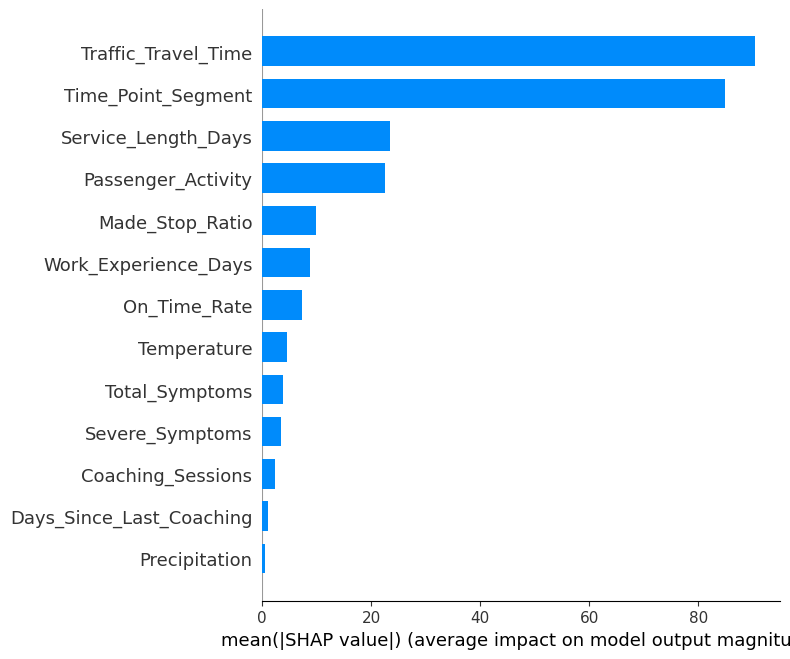

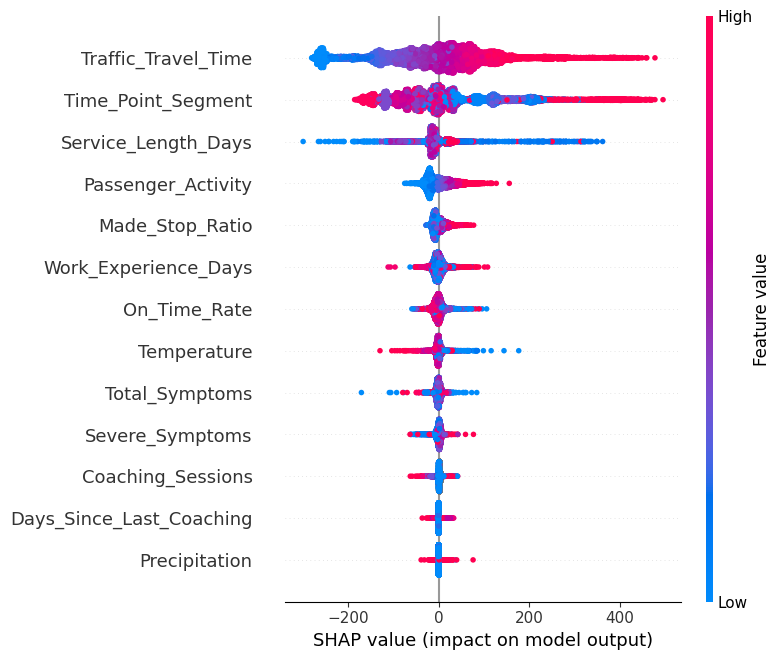

In [ ]:
# Create explainer
explainer = shap.Explainer(xgb_model, X_train)

# Compute SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")  # bar chart of feature importance
shap.summary_plot(shap_values, X_test)  # beeswarm plot for feature-level impacts

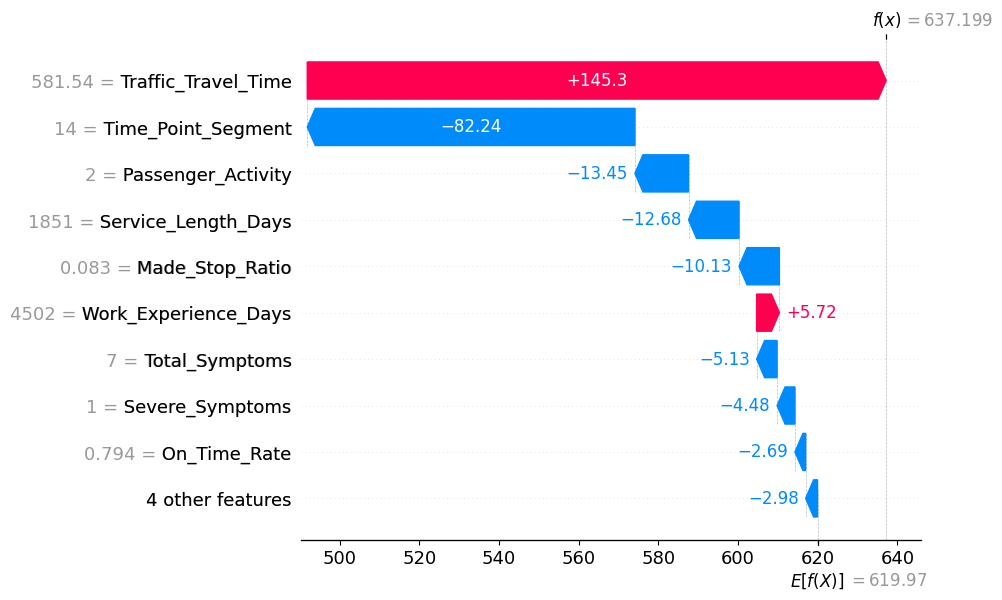

In [ ]:
shap.plots.waterfall(shap_values[600])

For an individual prediction, how does SHAP quantify the effect of the features on travel time.

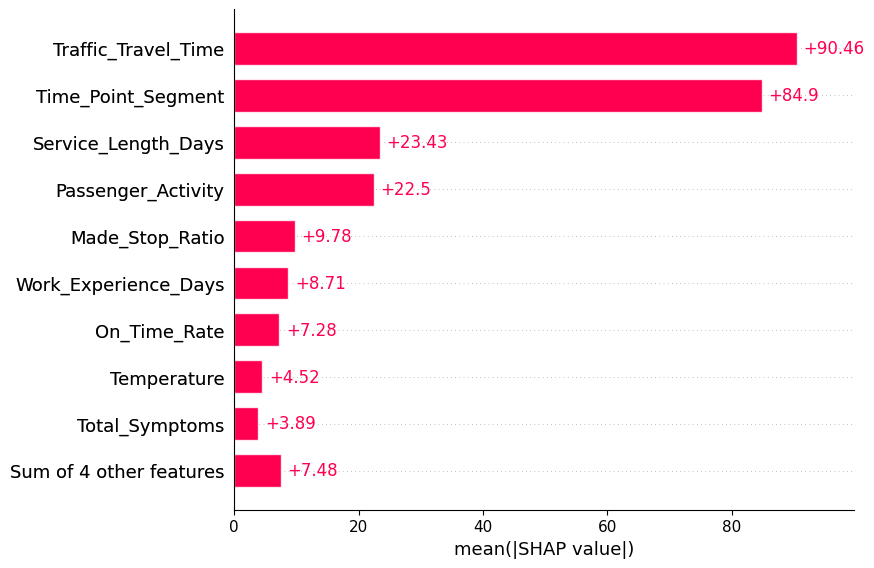

In [ ]:
shap.plots.bar(shap_values)

On the aggregate level, this shows the average impact whether positive or negative a feature has on travel time.

In [288]:
# Assuming shap_values is a SHAP values object for a single model (e.g., from TreeExplainer)
mean_shap = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame with feature names
shap_summary_df = pd.DataFrame({
    'feature': shap_values.feature_names,
    'mean_abs_shap': mean_shap
})

# Sort by importance
shap_summary_df = shap_summary_df.sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

shap_summary_df


,feature,mean_abs_shap
0,Traffic_Travel_Time,90.457831
1,Time_Point_Segment,84.895010
2,Service_Length_Days,23.430648
3,Passenger_Activity,22.495391
4,Made_Stop_Ratio,9.783090
5,Work_Experience_Days,8.707531
6,On_Time_Rate,7.282714
7,Temperature,4.520502
8,Total_Symptoms,3.891356
9,Severe_Symptoms,3.506417


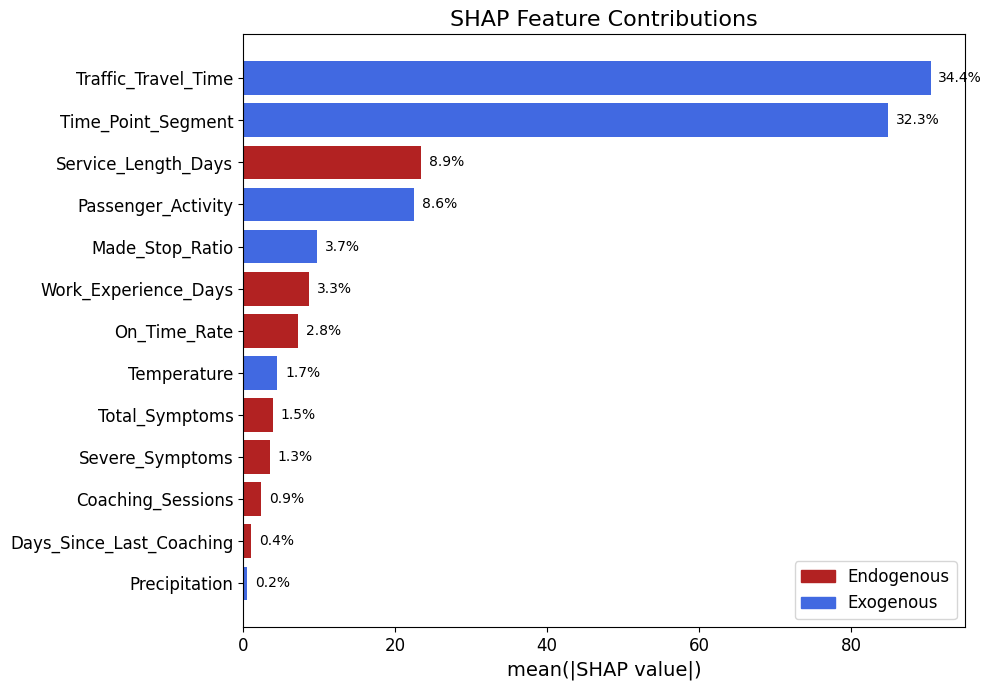

In [292]:
# Step 1: Use your SHAP mean values
summary_df = pd.DataFrame({
    'Feature': [
        'Traffic_Travel_Time', 'Time_Point_Segment', 'Service_Length_Days', 
        'Passenger_Activity', 'Made_Stop_Ratio', 'Work_Experience_Days', 
        'On_Time_Rate', 'Temperature', 'Total_Symptoms', 'Severe_Symptoms', 
        'Coaching_Sessions', 'Days_Since_Last_Coaching', 'Precipitation'
    ],
    'mean_SHAP': [
        90.457831, 84.895010, 23.430648, 22.495391, 9.783090, 8.707531,
        7.282714, 4.520502, 3.891356, 3.506417, 2.367797, 1.052291, 0.550150
    ]
})

# Step 2: Define feature categories
endogenous = [
    'Coaching_Sessions', 'On_Time_Rate', 'Days_Since_Last_Coaching',
    'Work_Experience_Days', 'Total_Symptoms', 'Severe_Symptoms', 'Service_Length_Days'
]

exogenous = [
    'Made_Stop_Ratio', 'Passenger_Activity', 'Temperature',
    'Precipitation', 'Traffic_Travel_Time', 'Time_Point_Segment'
]

# Step 3: Classify features by type
def classify_feature(feature):
    if feature in exogenous:
        return 'Exogenous'
    elif feature in endogenous:
        return 'Endogenous'
    else:
        return 'Unknown'

summary_df['Category'] = summary_df['Feature'].apply(classify_feature)

# Step 4: Assign colors based on category
color_map = {
    'Exogenous': 'royalblue',
    'Endogenous': 'firebrick',
}
summary_df['Color'] = summary_df['Category'].map(color_map)

# Step 5: Calculate % contribution and sort
summary_df['Percent'] = summary_df['mean_SHAP'] / summary_df['mean_SHAP'].sum() * 100
summary_df = summary_df.sort_values('mean_SHAP', ascending=True)

# Step 6: Plot
plt.figure(figsize=(10, 7))
bars = plt.barh(summary_df['Feature'], summary_df['mean_SHAP'], color=summary_df['Color'])

# Add % labels
for bar, pct in zip(bars, summary_df['Percent']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f'{pct:.1f}%', va='center', fontsize=10)

plt.xlabel("mean(|SHAP value|)", fontsize=14)
plt.title("SHAP Feature Contributions", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[
    plt.Rectangle((0, 0), 1, 1, color='firebrick', label='Endogenous'),
    plt.Rectangle((0, 0), 1, 1, color='royalblue', label='Exogenous'),
], fontsize=12)

plt.tight_layout()
plt.show()


The features quantified as a percentage of contribution for SHAP

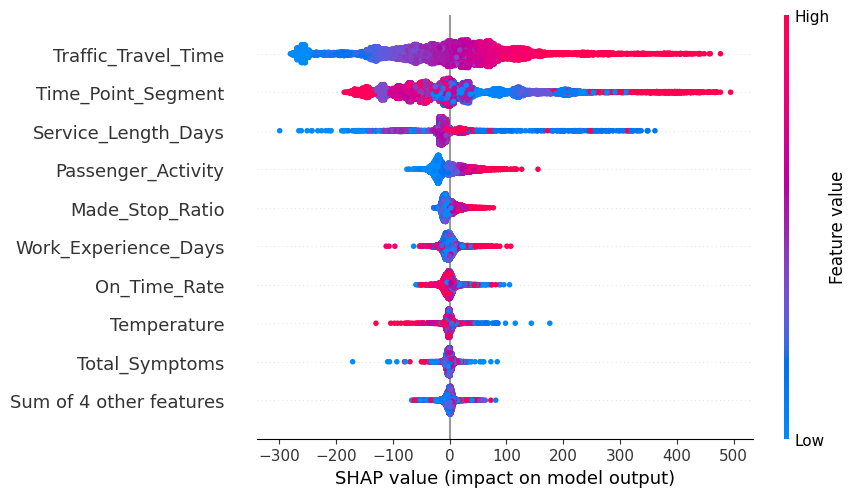

In [ ]:
shap.plots.beeswarm(shap_values)

Beswarm plot shows the directional impact on travel time based on the direction of the feature. Please ignore the time point segment as this is a categorical variable that has a label.

# Analyzing SHAP for Length of Service Variable

In [ ]:
# Step 1: Get SHAP values for Made_Stop_Ratio
length_of_service_shap = shap_values.values[:, X_test.columns.get_loc("Service_Length_Days")]

# Step 2: Create a DataFrame combining X_test and SHAP values
shap_df = X_test.copy()
shap_df["Service_Length_Days_SHAP"] = length_of_service_shap
shap_df['actual_travel_time'] = y_test

# Step 3: Filter for slength of service  with negative SHAP impact
high_impact_shap = shap_df[
    (shap_df["Service_Length_Days"] >= 2000) &
    (
        (shap_df["Service_Length_Days_SHAP"] < 0) #|
        #(shap_df["Service_Length_Days_SHAP"] > 50)
    )
]


# Optional: Sort by most negative impact
high_ratio_negative_shap = high_impact_shap.sort_values(by="Service_Length_Days_SHAP")

# Display the top few
high_ratio_negative_shap.to_csv('Length of Service SHAP.csv')


Further analysis into why low length of service shows high impact for increasing and decreasing travel time.

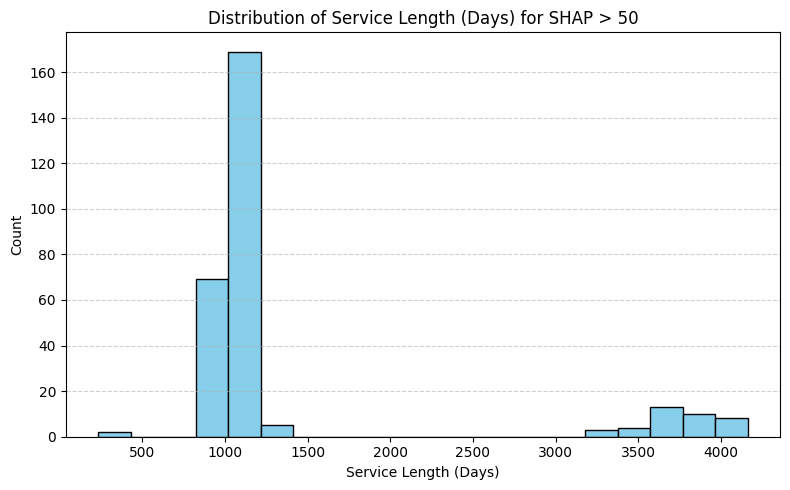

In [ ]:
# Plot histogram of Service_Length_Days 
plt.figure(figsize=(8, 5))
plt.hist(high_impact_shap['Service_Length_Days'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Service Length (Days) for SHAP > 50')
plt.xlabel('Service Length (Days)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

It shows that mostly newer vehicles are having a strong positive impact on travel time.

In [ ]:
# Filter to relevant timepoints and service length
target_segments = [0, 1, 2, 20]
another_df = shap_df[
    (shap_df['Time_Point_Segment'].isin(target_segments)) &
    (shap_df['Service_Length_Days'] > 2000)
]

for segment in target_segments:
    segment_data = another_df[another_df['Time_Point_Segment'] == segment]['Service_Length_Days_SHAP']
    
    total = len(segment_data)
    below_zero = (segment_data < 0).sum()
    above_zero = (segment_data > 0).sum()
    
    print(f"Timepoint {segment}:")
    print(f"  % Below 0: {below_zero / total:.1%}")
    print(f"  % Above 0: {above_zero / total:.1%}\n")


Timepoint 0:
  % Below 0: 100.0%
  % Above 0: 0.0%

Timepoint 1:
  % Below 0: 95.0%
  % Above 0: 5.0%

Timepoint 2:
  % Below 0: 91.1%
  % Above 0: 8.9%

Timepoint 20:
  % Below 0: 11.9%
  % Above 0: 88.1%



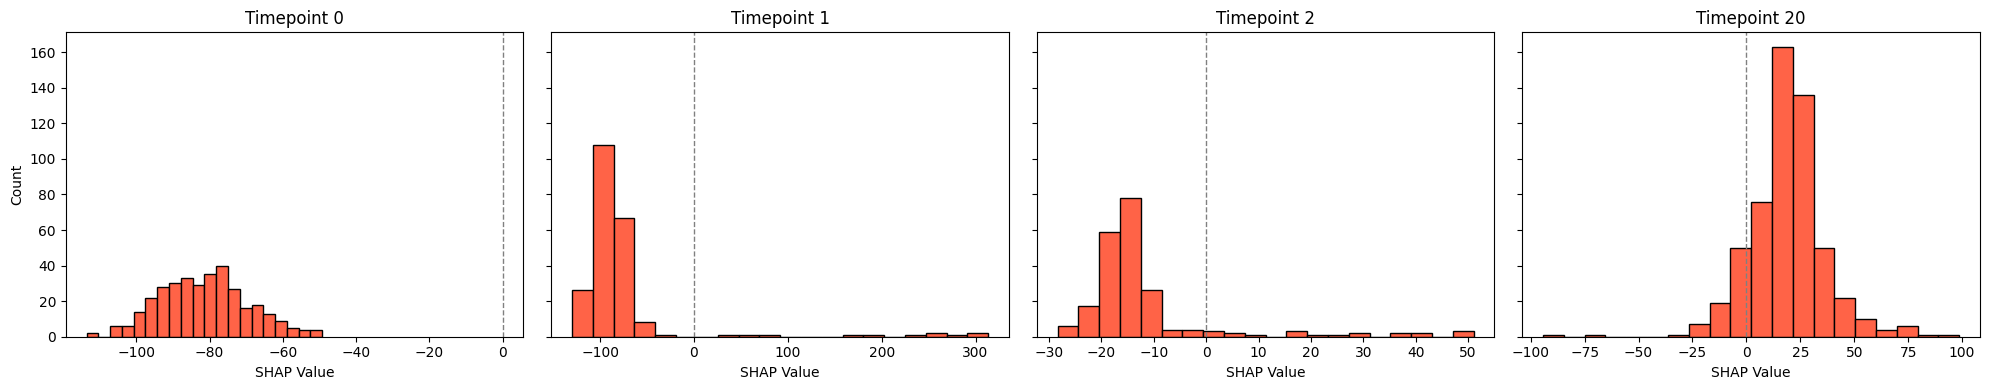

In [ ]:
# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)

# Plot histogram for each timepoint
for i, segment in enumerate(target_segments):
    ax = axes[i]
    segment_data = another_df[another_df['Time_Point_Segment'] == segment]['Service_Length_Days_SHAP']
    
    ax.hist(segment_data, bins=20, color='tomato', edgecolor='black')
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title(f"Timepoint {segment}")
    ax.set_xlabel("SHAP Value")
    if i == 0:
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


The length of service clusters around a certain value for SHAP impact for all 4 timepoints. However if we look at timepoints 1 and 2, these SHAP values tend to be negative values, but they have some positive impacts, and I need to investigate why.

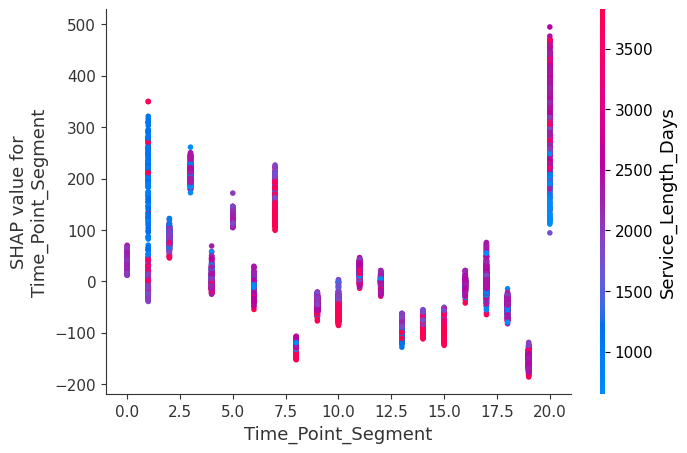

In [ ]:
shap.dependence_plot(
    "Time_Point_Segment",
    shap_values.values,
    X_test,
    interaction_index="Service_Length_Days"  # you can try other columns too
)

This plot shows that for every timeopint, how does the SHAP value correspond to the distribution of service length days.

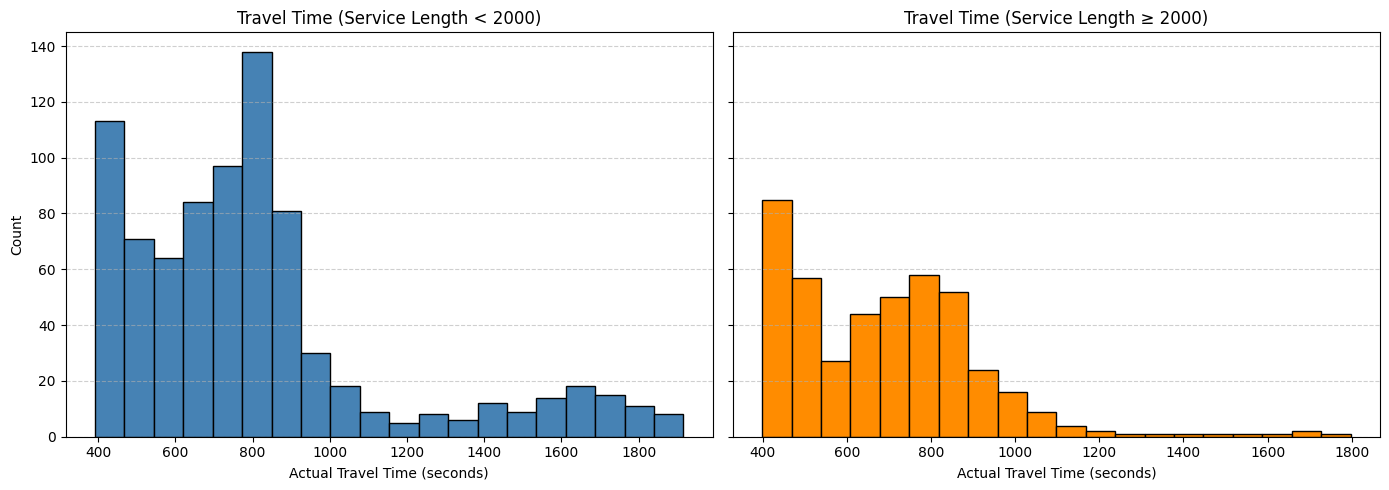

In [ ]:
# Filter to Timepoints 1 and 2
subset_df = shap_df[shap_df['Time_Point_Segment'].isin([1, 2])]

# Group 1: Service_Length_Days < 2000
group1 = subset_df[subset_df['Service_Length_Days'] < 2000]['actual_travel_time']

# Group 2: Service_Length_Days >= 2000
group2 = subset_df[subset_df['Service_Length_Days'] >= 2000]['actual_travel_time']

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(group1, bins=20, color='steelblue', edgecolor='black')
axes[0].set_title('Travel Time (Service Length < 2000)')
axes[0].set_xlabel('Actual Travel Time (seconds)')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

axes[1].hist(group2, bins=20, color='darkorange', edgecolor='black')
axes[1].set_title('Travel Time (Service Length ≥ 2000)')
axes[1].set_xlabel('Actual Travel Time (seconds)')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



For timepoint mappings 1 & 2, we see that newer buses tend to driven on trips with longer travel times than older buses. Hence, the model reocgnized this pattern and attributes new buses with high travel times. 